# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import missingno as msno
from googletrans import Translator

# import sys
# from IPython.display import display
# import pprint
# import itertools
# import math
# import nltk
# from nltk.corpus import wordnet

'''
custom modules
'''
# function similar to Excel's vlookup
from vlookup import vlookup
# function to view all contents of a dataframe
from view_all import view_all

In [2]:
# pip install googletrans==4.0.0-rc1
# pip install missingno
# custom modules for convenience are in root folder

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Load and overview

#### 1.1 azdias

In [3]:
# 제출전 주석 해제
# '''
# load and file overview
# '''

# azdias = pd.read_csv('../csv_pickle/Udacity_AZDIAS_052018.csv', sep=';')
# azdias.name = 'azdias'
# print (azdias.shape)
# azdias.head()

In [4]:
azdias = pd.read_pickle('../csv_pickle/azdias.pickle')

print (azdias.info())
azdias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


**[function]** miss_val_overview

In [5]:
def miss_val_overview(df, chunk_size = 100):
    '''
    function to display missing value using missingno(msno) library
    df: dataframe
    chunk_size: int, size of column chunk, 100 as default  
    '''
    # split df columns into chunks
    chunk_size = chunk_size
    column_chunks = [df.iloc[:, i : i + chunk_size] for i in range(0, df.shape[1], chunk_size)]

    # generate and display missingno plots for each chunk
    for i, j in enumerate(column_chunks):
        msno.matrix(j, figsize = (10, 3), fontsize = 8, labels = False, sparkline = False)
        plt.title(
            f'{df.name}: missing value overview - column {i * 100} to {min (i * chunk_size + chunk_size - 1, df.shape[1] - 1)}',
            fontsize = 10);

In [6]:
# '''
# missing value overview
# '''

# azdias.name = 'azdias'
# miss_val_overview(azdias)

#### 1.2 customers

In [7]:
# 제출전 주석 해제
# '''
# load and file overview
# '''

# customers = pd.read_csv('../csv_pickle/Udacity_CUSTOMERS_052018.csv', sep=';')
# print (customers.info())
# customers.head()

In [8]:
customers = pd.read_pickle('../csv_pickle/customers.pickle')

print (customers.info())
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
# '''
# missing value overview
# '''

# customers.name = 'customers'
# miss_val_overview(customers)

#### 1.3 info

In [10]:
'''
load and overview
'''

info = pd.read_excel(
    'DIAS Information Levels - Attributes 2017.xlsx', header=1).iloc[:, 1:]

print (info.info())
info.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  10 non-null     object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB
None


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN


#### 1.4 attr

In [11]:
'''
load and overview
'''

attr = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', header=1).iloc[:, 1:]
# rename column Value to Score for easier documentation
attr = attr.rename(columns = {'Value' : 'Score'})

print (attr.info())
attr[103:108]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Score        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None


,Attribute,Description,Score,Meaning
103,NaN,NaN,9D,Mini-Jobber
104,NaN,NaN,9E,Socking Away
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,NaN,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,NaN,NaN,12,Wealthy Households-Young Couples With Children


### 2. Baseline understanding

**2자리 넘버링으로 정리 되도록 함**

There are 4 files given:
* 2 dataset files - azdias & customers
* 2 reference files - info & attr:  
  - info is for information on dataset features which are in unreadable German acronyms  
  - attr is for information on dataset values which are in numbers and acronyms,  
  and has corresponding meanings  

To establish a baseline, this section aims to identify key factors in the reference files   
that can help in understanding the contents of the dataset.

#### 2.1 feature reference

As datasets do not have information on what each column feature exactly means,  
values of reference files have to be mapped to the features.
  
feature_desc below is for this needs, and formed with 369 column features from customers. 

In [12]:
'''
feature_desc with column features of customers and added information from info 
'''

feature_desc = pd.DataFrame(customers.columns, columns=['Attribute'])
feature_desc = vlookup(feature_desc, info, 'Attribute')
# custom function vlookup is similar to Excel's vlookup

feature_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Attribute          369 non-null    object
 1   Information level  9 non-null      object
 2   Description        264 non-null    object
 3   Additional notes   17 non-null     object
dtypes: object(4)
memory usage: 14.4+ KB


After merging information columns, there are 264 features from both customers and info,  
along with 105 exclusive features of customers lacking Description values.  

To fill the 105 missing Descriptions, 12 values are added from the reference file attr,  
and translation values are created using the googletrans module.  
The resulting dataframe is saved in the root folder due to the time-consuming code execution.

In [13]:
# # For values of Attribute without Description, add 12 Description values from attr
# attr_to_add = attr[['Attribute', 'Description']].copy()
# attr_to_add.dropna(inplace = True)
# attr_to_add = attr_to_add.rename(columns = {'Description': 'Description_to_add'})

# feature_desc = vlookup(feature_desc, attr_to_add, 'Attribute')
# feature_desc.Description = np.where(
#     ((feature_desc.Description.isnull() == True) & (feature_desc.Description_to_add.isnull() == False)),
#     feature_desc.Description_to_add,
#     feature_desc.Description)
# feature_desc = feature_desc.drop('Description_to_add', axis=1)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# feature_desc['ger_to_eng'] = np.where(
#     feature_desc.Description.isnull(),
#     feature_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# feature_desc['Desc'] = feature_desc.Description.fillna('') + feature_desc.ger_to_eng.fillna('')

feature_desc = pd.read_excel('feature_desc.xlsx', index_col = [0])
feature_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Attribute          369 non-null    object
 1   Information level  9 non-null      object
 2   Description        276 non-null    object
 3   Additional notes   17 non-null     object
 4   ger_to_eng         93 non-null     object
 5   Desc               369 non-null    object
dtypes: object(6)
memory usage: 20.2+ KB


In [14]:
'''
understand all features one by one using custom function view_all

not to run this cell, to save space in the final submission 
'''

# view_all(feature_desc)

feature_desc.head()

,Attribute,Information level,Description,Additional notes,ger_to_eng,Desc
0,LNR,NaN,NaN,NaN,LNR,LNR
1,AGER_TYP,NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...,NaN,best-ager typology
2,AKT_DAT_KL,NaN,NaN,NaN,Act Dat KL,Act Dat KL
3,ALTER_HH,Household,main age within the household,NaN,NaN,main age within the household
4,ALTER_KIND1,NaN,NaN,NaN,Old child1,Old child1


The improved readability of feature_desc has enhanced the understanding  
of the overall structure of the datasets and the meanings of the features,  
although some translations still remain unclear.  

Since there are a few features that have similar contents, it is necessary  
to perform imputation steps to resolve collinearity and reduce dimensionality  
before proceeding with the modeling process.

In [15]:
# p_process below is a dict formed to record points to be pre-processed in the following sections.

# '''
# p_process dict to record points to be pre_processed
# '''

# p_process = {'2.1' : 'features of similar contents: collinearity resolution & dimensionality reduction'}

#### 2.2 feature alignment

The following cells provide an overview of the number of features in each file  
and illustrates the feature intersection and difference between the files.

In [16]:
feature_dict = {
    'azdias' : set(azdias.columns.unique()),
    'customers' : set(customers.columns.unique()),
    'info' : set(info.Attribute.dropna().unique()),
    'attr' : set(attr.Attribute.dropna().unique()),
    'feature_desc' : set(feature_desc.Attribute.dropna().unique())
    }

print ('Number of features by file')
for k, v in feature_dict.items():
    print (k, ':', len(v))

Number of features by file
azdias : 366
customers : 369
info : 313
attr : 314
feature_desc : 369


In [17]:
print ('Feature intersection & difference between files')
for i in range(0, 5):
    for j in range (0, 5):
        if i == j:
            continue
        
        key_1 = list(feature_dict.keys())[i]
        key_2 = list(feature_dict.keys())[j]
        set_1 = list(feature_dict.values())[i]
        set_2 = list(feature_dict.values())[j]
        
        intsec = set_1.intersection(set_2)
        ft_diff = set_1 - set_2
        feature_dict[f'{key_1}_intsec_{key_2}'] = intsec
        feature_dict[f'in_{key_1}_notin_{key_2}'] = ft_diff
        
        intsec_print = f'{key_1} & {key_2} intersection:'
        ft_diff_print = f' /  in {key_1} & not-in {key_2}:'        
        print (intsec_print, str(len(intsec)).rjust(41 - len(intsec_print)),
               ft_diff_print, str(len(ft_diff)).rjust(40 - len(ft_diff_print)))

Feature intersection & difference between files
azdias & customers intersection:       366  /  in azdias & not-in customers:       0
azdias & info intersection:            264  /  in azdias & not-in info:          102
azdias & attr intersection:            272  /  in azdias & not-in attr:           94
azdias & feature_desc intersection:    366  /  in azdias & not-in feature_desc:    0
customers & azdias intersection:       366  /  in customers & not-in azdias:       3
customers & info intersection:         264  /  in customers & not-in info:       105
customers & attr intersection:         272  /  in customers & not-in attr:        97
customers & feature_desc intersection: 369  /  in customers & not-in feature_desc: 0
info & azdias intersection:            264  /  in info & not-in azdias:           49
info & customers intersection:         264  /  in info & not-in customers:        49
info & attr intersection:              300  /  in info & not-in attr:             13
info & feature_de

#### 2.3 dataset values

After identifying the dataset structure in parts 2.1 and 2.2 above,  
part 2.3 focuses on examining the dataset contents.  
In this part, various aspects such as the ranges of feature values,  
values actually meaning null, data types, and more are to be verified,  
and preliminary notes will be recorded on pre-processing requirements.

##### 2.3.0 attr modification

Considering that info contains information about dataset features, attr contains  
information about dataset values and the values within the datasets can be understood  
by mapping them to the corresponding Meaning values in attr.

However, it is necessary to initially modify attr since it is not in a neat form.

In [18]:
'''
some Description cells have minor add-on information below
which should be merged
'''
 # keep original attr file
attr_org = attr.copy()

# merge minor information cells
attr['description_shift'] = attr.Description.shift(-1).fillna('')
attr.Description = attr.Description.mask(
    ~(attr['Attribute'].isna()),
    attr.Description + ' ' + attr.description_shift)
attr.Description = attr.Description.mask(
    (attr['Attribute'].isna()) & ~(attr['Description'].isna()),
    np.nan)
attr = attr.drop(columns = 'description_shift')

'''
fill null as only 1st lines of Attribute & Description have values
'''
attr[['Attribute', 'Description']] = attr[
    ['Attribute', 'Description']].fillna(method = 'ffill')

print (attr.info())
attr.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    2258 non-null   object
 1   Description  2258 non-null   object
 2   Score        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None


,Attribute,Description,Score,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


After modifying the attribute file to have well-organized data values,  
it is filtered to retain only 272 intersection features with customers.  
This filtering process involves dropping the exclusive features of attr  
that are not useful for analyzing the datasets of customers and azdias.

In [19]:
'''
extract 272 intersection features
'''
intsec_ft = feature_dict['attr_intsec_customers']
attr = attr[attr.Attribute.isin(intsec_ft)]

print (attr.Attribute.nunique())

272


In the last step of modifying attr, column Score_form is added  
to classify 272 features into 2 categories based on value forms in Score.

In [20]:
attr['Score_form'] = attr.Score.map(type)
attr.Score_form.value_counts()

<class 'int'>    1774
<class 'str'>     142
Name: Score_form, dtype: int64

##### 2.3.1 features with numeric Score values

Out of 272 features, 264 features are extracted with the condition  
that values within column Score are of numeric form.

In [21]:
'''
attr_num containing Score values in numeric form
'''

attr_num = attr[attr.Score_form == int]
attr_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 2257
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    1774 non-null   object
 1   Description  1774 non-null   object
 2   Score        1774 non-null   object
 3   Meaning      1763 non-null   object
 4   Score_form   1774 non-null   object
dtypes: object(5)
memory usage: 83.2+ KB


* **Score values lacking Meaning values**
    
  A small issue detected here is that there are 11 lines without value of Meaning.  
  From the examination below, 2 features involved with these lines can be dropped,  
  as they have other features with similar but more detailed Meaning values.

In [22]:
'''
2 features involved with lines without Meaning values
'''
attr_num[attr_num.Meaning.isnull()]

,Attribute,Description,Score,Meaning,Score_form
1906,LP_FAMILIE_GROB,familytyp rough,4,NaN,<class 'int'>
1907,LP_FAMILIE_GROB,familytyp rough,5,NaN,<class 'int'>
1909,LP_FAMILIE_GROB,familytyp rough,7,NaN,<class 'int'>
1910,LP_FAMILIE_GROB,familytyp rough,8,NaN,<class 'int'>
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN,<class 'int'>
1913,LP_FAMILIE_GROB,familytyp rough,11,NaN,<class 'int'>
1977,LP_STATUS_GROB,social status rough,2,NaN,<class 'int'>
1979,LP_STATUS_GROB,social status rough,4,NaN,<class 'int'>
1980,LP_STATUS_GROB,social status rough,5,NaN,<class 'int'>
1982,LP_STATUS_GROB,social status rough,7,NaN,<class 'int'>


In [23]:
'''
these 2 features can be dropped, as they have other features
with similar but more detailed Meaning value
'''
lp_gros_fine = attr[attr.Attribute.str.contains('LP_FAMILIE') | attr.Attribute.str.contains('LP_STATUS')]
lp_gros_fine[lp_gros_fine['Score'] > 8]

,Attribute,Description,Score,Meaning,Score_form
1900,LP_FAMILIE_FEIN,familytyp fine,9,shared flat,<class 'int'>
1901,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household,<class 'int'>
1902,LP_FAMILIE_FEIN,familytyp fine,11,multi-generational household,<class 'int'>
1911,LP_FAMILIE_GROB,familytyp rough,9,multiperson household,<class 'int'>
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN,<class 'int'>
1913,LP_FAMILIE_GROB,familytyp rough,11,NaN,<class 'int'>
1974,LP_STATUS_FEIN,social status fine,9,houseowners,<class 'int'>
1975,LP_STATUS_FEIN,social status fine,10,top earners,<class 'int'>
1984,LP_STATUS_GROB,social status rough,9,NaN,<class 'int'>
1985,LP_STATUS_GROB,social status rough,10,top earners,<class 'int'>


**[Note]** p_process below is a dict formed to note points to be pre-processed in the following sections.

In [24]:
p_process = {'2.3.1' : 'drop features LP_FAMILIE_GROB / LP_STATUS_GROB'}

After dropping 2 features, remaining features are further organized into groups  
based on min/max values observed.

In [70]:
'''
drop 2 features from attr_num
'''
attr_num = attr_num[(~attr_num['Attribute'].isin(['LP_FAMILIE_GROB', 'LP_STATUS_GROB']))]

'''
pivot table summary of attr_num with min/max value categories
'''
print (f'{attr_num.Attribute.nunique()} features grouped by min/max values')
pv_min_max = pd.pivot_table(
    attr_num,
    index = ['Attribute', 'Description'],
    values = 'Score',
    aggfunc = [min, max]
    )
pv_min_max['min_max_cat'] = pv_min_max['min'].astype(int).astype(str) + ' to ' + pv_min_max['max'].astype(int).astype(str)
pv_min_max = pv_min_max.sort_values(by = 'min_max_cat')

pv_min_max.min_max_cat.unique()

262 features grouped by min/max values


array(['-1 to -1', '-1 to 2', '-1 to 3', '-1 to 4', '-1 to 5', '-1 to 6',
       '-1 to 7', '-1 to 8', '-1 to 9', '0 to 1', '0 to 10', '0 to 21',
       '0 to 3', '0 to 4', '0 to 5', '0 to 6', '1 to 10', '1 to 11',
       '1 to 12', '1 to 15', '1 to 2', '1 to 3', '1 to 4', '1 to 40',
       '1 to 5', '1 to 6', '1 to 7', '1 to 8', '1 to 9'], dtype=object)

From min/max categories above, to be further checked are:   
* If Score -1 and 0 contain data equal to null or -inf  
* If max Score values contain data equal to null or inf
* If features with wider min/max gap are discrete or continuous

* **Cases of Score -1 and 0**
     
  i) All Score value -1s in datasets should be replaced to null,  
    as the reference of attr shows that it always means unknown.

  ii) Few Score value 0s can be replaced to null if the corresponding  
    value of Meaning is in list to_null.

  iii) All other Score value 0s should be remained, as the reference  
    of attr shows value 0 is not meaning null in nearly all cases.  

  Analyses for this conclusion are in the following cells.

In [26]:
'''
when Score value is -1, the meaning is 100% unknown in reference file
'''

attr_num_mn1 = attr_num[attr_num.Score == -1]
attr_num_mn1.Meaning.value_counts()

unknown    133
Name: Meaning, dtype: int64

In [27]:
'''
when Score value is 0, it means none in most occasion,
and there are few cases observed that the corresponding value
of Meaning is definitely equal to null
'''

attr_num_0 = attr_num[attr_num.Score == 0]
attr_num_0.Meaning.value_counts()

none                                                136
no transactions known                                10
no Online-transactions within the last 12 months      3
unknown                                               2
no classification possible                            1
unknown / no main age detectable                      1
doesn't belong to the green avantgarde                1
classification not possible                           1
no 1-2 family homes                                   1
no 3-5 family homes                                   1
no 6-10 family homes                                  1
no >10 family homes                                   1
external supplied hedonists                           1
no score calculated                                   1
Name: Meaning, dtype: int64

**[function]** verify_null

In [28]:
def verify_null(data, null_list, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes']):
    '''
    function to display the summary of Score and Meaning values,
    when Meaning values are in the list containing possibly null values.   
    
    data: dataframe to examine
    null_list: list of possibly null values
    pv_idx: pivot_table index
    '''
    null_check_Attribute = data[data['Meaning'].isin(null_list)]['Attribute'].to_list()
    null_check = data[data['Attribute'].isin(null_check_Attribute)]
    
    null_check = vlookup(null_check, feature_desc, 'Attribute', ['Desc', 'Additional notes'], nan_val = 'no_info')
    pv = pd.pivot_table(
        null_check,
        index = pv_idx,
        values = ['Score', 'Meaning'],
        aggfunc = lambda x: list(x))
    
    return pv

In [29]:
'''
select Meaning values which seems to be definitely null,
and verify them
'''
to_null = ['unknown','no transactions known', 'no classification possible',
           'unknown / no main age detectable', 'classification not possible',
           'no score calculated'
            ]

verify_to_null = verify_null(attr_num, to_null)
view_all(verify_to_null.iloc[:5])

,,,,Meaning,Score
Attribute,Description,Desc,Additional notes,,
AGER_TYP,best-ager typology,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,"[unknown, no classification possible, passive elderly, cultural elderly, experience-driven elderly]","[-1, 0, 1, 2, 3]"
ALTER_HH,main age within the household,main age within the household,no_info,"[unknown / no main age detectable, 01.01.1895 bis 31.12.1899, 01.01.1900 bis 31.12.1904, 01.01.1905 bis 31.12.1909, 01.01.1910 bis 31.12.1914, 01.01.1915 bis 31.12.1919, 01.01.1920 bis 31.12.1924, 01.01.1925 bis 31.12.1929, 01.01.1930 bis 31.12.1934, 01.01.1935 bis 31.12.1939, 01.01.1940 bis 31.12.1944, 01.01.1945 bis 31.12.1949, 01.01.1950 bis 31.12.1954, 01.01.1955 bis 31.12.1959, 01.01.1960 bis 31.12.1964, 01.01.1965 bis 31.12.1969, 01.01.1970 bis 31.12.1974, 01.01.1975 bis 31.12.1979, 01.01.1980 bis 31.12.1984, 01.01.1985 bis 31.12.1989, 01.01.1990 bis 31.12.1994, 01.01.1995 bis 31.12.1999]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
BALLRAUM,distance to next urban centre,distance to the next metropole,no_info,"[unknown, till 10 km, 10 - 20 km, 20 - 30 km, 30 - 40 km, 40 - 50 km, 50-100 km, more than 100 km ]","[-1, 1, 2, 3, 4, 5, 6, 7]"
CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,CAMEO_4.0: uppergroup,New German CAMEO Typology established together with Call Credit in late 2015,"[unknown, upper class, upper middleclass, established middleclasse, consumption-oriented middleclass , active middleclass , low-consumption middleclass, lower middleclass, working class, urban working class]","[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
CJT_GESAMTTYP,customer journey typology,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combined via a statistical modell with AZ DIAS data","[unknown, Advertising- and Consumptionminimalist, Advertising- and Consumptiontraditionalist, advertisinginterested Store-shopper, advertisinginterested Online-shopper, Advertising- and Cross-Channel-Enthusiast, Advertising-Enthusiast with restricted Cross-Channel-Behaviour ]","[0, 1, 2, 3, 4, 5, 6]"


In [30]:
maybe_null = ['none']

'''
check if none is also equal to null and should be added to to_nul:
none does not mean null in any case (see examples below).
'''

verify_maybe_null = verify_null(attr_num, maybe_null)
view_all(verify_maybe_null.iloc[:5])

,,,,Meaning,Score
Attribute,Description,Desc,Additional notes,,
KBA05_ALTER1,share of car owners less than 31 years old,share of car owners less than 31 years old,no_info,"[none, low, average, high, very high]","[0, 1, 2, 3, 4]"
KBA05_ALTER4,share of cars owners elder than 61 years,share of cars owners elder than 61 years,no_info,"[none, very low, low, average, high, very high]","[0, 1, 2, 3, 4, 5]"
KBA05_ANHANG,share of trailers in the microcell,share of trailers in the microcell,no_info,"[none, some, some more, very many]","[0, 1, 2, 3]"
KBA05_CCM4,share of cars with more than 2499ccm,share of cars with more than 2499ccm,no_info,"[none, low, average, high, very high]","[0, 1, 2, 3, 4]"
KBA05_DIESEL,share of cars with Diesel-engine in the microcell,share of cars with Diesel-engine in the microcell,no_info,"[none, very low, low, average, high]","[0, 1, 2, 3, 4]"


**[Note]** p_process

In [31]:
p_process['2.3.1-value_-1'] = 'All value -1s in datasets to be null'
p_process['2.3.1-value_0'] = 'Value 0s to be null if corresponding Meaning value is in to_null'

* **max Score values**  
  
  some Meaning values linked to max Scores seem to possibly be null.  
  However most of them are not verified as null or already in list to_null. 

In [32]:
'''
extract Meaning values corresponding to max Score values
'''
attr_num['Score'] = attr_num['Score'].astype(float)
max_idx = attr_num.groupby('Attribute')['Score'].idxmax()

attr_num_max = attr_num.loc[max_idx]
attr_num_max.Meaning.unique()

array(['experience-driven elderly', 'uniformly distributed',
       '01.01.1995 bis 31.12.1999', 'female', 'more than 100 km ',
       'urban working class',
       'Advertising-Enthusiast with restricted Cross-Channel-Behaviour ',
       'very high activity', 'no transactions known',
       '100% Online-transactions within the last 12 months', 'Inactive',
       'more than 999 HH/²', 'unremarkable', 'very low',
       'mixed building without actually known company ',
       'residential cell', 'without vacation',
       'belongs to the green avantgarde', 'jaunty hedonists ',
       'very low income', 'distance to the city centre > 40 km',
       'very high', 'very many', 'very high share of 1-2 family homes',
       'very high share of 3-5 family homes',
       'high share of 6-10 family homes',
       'high share of >10 family homes', 'very high car quote',
       'mainly business buildings in the microcell', 'high',
       '>=23 buildings', 'new building', 'way above average',
     

In [33]:
'''
select Meaning values to be checked
'''
maybe_null = ['uniformly distributed', 'no transactions known', 'Inactive', 'unremarkable',
              'unknown', 'other', 'indifferent']

maybe_null = [i for i in maybe_null if i not in to_null]
maybe_null

['uniformly distributed', 'Inactive', 'unremarkable', 'other', 'indifferent']

In [34]:
'''
check if Meaning values of maybe_null should be added to to_nul
'''

verify_maybe_null = verify_null(attr_num, maybe_null)
view_all(verify_maybe_null.iloc[:5])

,,,,Meaning,Score
Attribute,Description,Desc,Additional notes,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,age through prename analysis,modelled on millions of first name-age-reference data,"[< 30 years, 30 - 45 years, 46 - 60 years, > 60 years, uniformly distributed]","[1.0, 2.0, 3.0, 4.0, 9.0]"
D19_KONSUMTYP,consumption type,consumption type,no_info,"[Universal, Versatile, Gourmet, Family, Informed , Modern, Inactive]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0]"
FINANZTYP,best descirbing financial type for the person,best descirbing financial type for the peron,no_info,"[unknown, low finacial interest, money saver, main focus is the own house, be prepared, Investor, unremarkable]","[-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]"
TITEL_KZ,flag whether this person holds an academic title,flag whether this person holds an academic title,no_info,"[Dr., Dr. Dr., Prof., Prof. Dr., other]","[1.0, 2.0, 3.0, 4.0, 5.0]"
ZABEOTYP,typification of energy consumers,typification of energy consumers,modelled on different AZ DIAS data,"[green, smart, fair supplied, price driven, seeking orientation, indifferent]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]"


In [35]:
'''
form list maybe_null only inactive can be regarded as null
'''

to_null.append('Inactive')

* **Data type of features with wider min/max Score gap**
  
  All features that have min/max Score gap over 7 are found to be discrete

**[function]** score_meaning_val

In [49]:
def meaning_score_val(data, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes']):
    '''
    function to display the summary of Score and Meaning values
    data : dataframe to examine
    pv_idx: list of pivot_table index
    '''
    data = vlookup(data, feature_desc, 'Attribute', ['Desc', 'Additional notes'], nan_val = 'no_info')
    pv = pd.pivot_table(
        data,
        index = pv_idx,
        values = ['Meaning', 'Score'],
        aggfunc = lambda x: list(x))
    
    return pv

In [50]:
'''
All features that have min/max Score gap over 7 are found to be discrete
'''
# from pv_min_max above, extract Attribute values having Score values over 7
max_over_7_Attribute = pv_min_max[pv_min_max[('max', 'Score')] > 7].index.get_level_values(0)
max_over_7 = attr_num[attr_num['Attribute'].isin(max_over_7_Attribute)]

pv_max_over_7 = meaning_score_val(max_over_7)
view_all(pv_max_over_7.iloc[:5])

,,,,Meaning,Score
Attribute,Description,Desc,Additional notes,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,age through prename analysis,modelled on millions of first name-age-reference data,"[< 30 years, 30 - 45 years, 46 - 60 years, > 60 years, uniformly distributed]","[1.0, 2.0, 3.0, 4.0, 9.0]"
ALTER_HH,main age within the household,main age within the household,no_info,"[unknown / no main age detectable, 01.01.1895 bis 31.12.1899, 01.01.1900 bis 31.12.1904, 01.01.1905 bis 31.12.1909, 01.01.1910 bis 31.12.1914, 01.01.1915 bis 31.12.1919, 01.01.1920 bis 31.12.1924, 01.01.1925 bis 31.12.1929, 01.01.1930 bis 31.12.1934, 01.01.1935 bis 31.12.1939, 01.01.1940 bis 31.12.1944, 01.01.1945 bis 31.12.1949, 01.01.1950 bis 31.12.1954, 01.01.1955 bis 31.12.1959, 01.01.1960 bis 31.12.1964, 01.01.1965 bis 31.12.1969, 01.01.1970 bis 31.12.1974, 01.01.1975 bis 31.12.1979, 01.01.1980 bis 31.12.1984, 01.01.1985 bis 31.12.1989, 01.01.1990 bis 31.12.1994, 01.01.1995 bis 31.12.1999]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0]"
CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,CAMEO_4.0: uppergroup,New German CAMEO Typology established together with Call Credit in late 2015,"[unknown, upper class, upper middleclass, established middleclasse, consumption-oriented middleclass , active middleclass , low-consumption middleclass, lower middleclass, working class, urban working class]","[-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]"
D19_BANKEN_DATUM,actuality of the last transaction for the segment banks TOTAL,actuality of the last transaction for the segment banks TOTAL,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 1 year, activity elder than 1,5 years, activity elder than 2 years, activity elder than 3 years, no transactions known]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]"
D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segment banks OFFLINE,actuality of the last transaction for the segment banks OFFLINE,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 12 months, activity elder than 18 months, activity elder than 24 months, activity elder than 36 months, no transactions known]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]"


##### 2.3.2 str values

///// 98 features in str type are analyzed

In [116]:
attr_str = attr[attr.Score_form == str]

print ('number of features in str type:', attr_str.Attribute.nunique())
print ('number of intersection features in int & str type:',
       len(set(attr_str.Attribute.unique()).intersection(set(attr_num.Attribute.unique()))), '\n')

pv_attr_str = meaning_score_val(attr_str)
view_all(pv_attr_str.iloc[:1])

number of features in str type: 98
number of intersection features in int & str type: 90 



,,,,Meaning,Score
Attribute,Description,Desc,Additional notes,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,age through prename analysis,modelled on millions of first name-age-reference data,[unknown],"[-1, 0]"


In [58]:
'''
As there are cases that 2 numbers paired are meaning 'unknown',  
the summary table is remade after deleting these lines.
'''

attr_str = attr_str[attr_str.Meaning != 'unknown']

pv_attr_str = meaning_score_val(attr_str)
view_all(pv_attr_str)

,,,,Meaning,Score
Attribute,Description,Desc,Additional notes,,
ANZ_HAUSHALTE_AKTIV,number of households in the building number of academic title holder in building,number of households known in this building,no_info,[numeric value (typically coded from 1-10)],[…]
ANZ_HH_TITEL,number of academic title holder in building number of adult persons in the household,number of holders of an academic title in the building,no_info,[numeric value (typically coded from 1-10)],[…]
ANZ_PERSONEN,number of adult persons in the household number of professional title holder in household,number of persons known in this household,no_info,[numeric value (typically coded from 1-3)],[…]
ANZ_TITEL,number of professional title holder in household distance to next urban centre,number of bearers of an academic title within this household,no_info,[numeric value (typically coded from 1-10)],[…]
CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification,CAMEO_4.0: specific group,no_info,"[Work-Life-Balance, Wealthy Best Ager, Successful Songwriter, Old Nobility, City Nobility, Cottage Chic, Noble Jogger, Established gourmet, Fine Management, Career & Family, Powershopping Families, Rural Neighborhood, Secure Retirement, Family Starter, Family Life, String Trimmer, Empty Nest, Golden Ager, Younger Employees, Suddenly Family, Family First, Stock Market Junkies, Coffee Rider, Active Retirement, Jobstarter, Petty Bourgeois, Long-established, Sportgardener, Urban Parents, Frugal Aging, Journeymen, Mantaplatte, Factory Worker, Rear Window, Interested Retirees, Multi-culteral, Young & Mobile, Prefab, Town Seniors, First Shared Apartment, Temporary Workers, Afternoon Talk Show, Mini-Jobber, Socking Away]","[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3C, 3D, 4A, 4B, 4C, 4D, 4E, 5A, 5B, 5C, 5D, 5E, 5F, 6A, 6B, 6C, 6D, 6E, 6F, 7A, 7B, 7C, 7D, 7E, 8A, 8B, 8C, 8D, 9A, 9B, 9C, 9D, 9E]"
GEBURTSJAHR,year of birth vacation habits,year of birth,no_info,[numeric value],[…]
KBA13_ANZAHL_PKW,number of cars in the PLZ8 share of AUDI within the PLZ8,number of cars in the PLZ8,no_info,[numeric value],[…]
MIN_GEBAEUDEJAHR,year the building was first mentioned in our database moving patterns,year the building was first mentioned in our database,no_info,[numeric value],[…]
OST_WEST_KZ,flag indicating the former GDR/FRG,flag indicating the former GDR/FRG,no_info,"[East (GDR), West (FRG)]","[O, W]"


From the observation above:
* 2 features are discrete - CAMEO_DEU_2015 and OST_WEST_KZ
* 7 features continuous that skewness of these features should be checked for scaling.

**[Note]** p_process

In [63]:
cont_feature = attr_str[attr_str['Meaning'].str.contains('numeric value')]
cont_ft = list(cont_feature['Attribute'].unique())

p_process['2.3.2'] = 'check skewness for scaling of ' + ', '.join(cont_ft)

### 3. Dataset exploration

Based on baseline understanding and frame works from reference files in section_2,  
section_3 is dealing with actual datasets.  
In this section, steps taken in the previous section will be repeated to fine-tune  
and finalize pro-processing items.

In [65]:
'''
create a concatenated dataframe of 2 datasets for temporary use
'''

concat_data = pd.concat([customers, azdias], axis=0)
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082873 entries, 0 to 891220
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(93), object(8)
memory usage: 3.0+ GB


#### 3.1 features with numeric Score form

///// For numeric features, concat_numeric including int and float type data is created.

In [66]:
concat_numeric = concat_data.select_dtypes(include = ['int', 'float']).copy()
concat_num = concat_numeric.copy()
concat_num.shape

(1082873, 361)

///// And concat_num with the summary statistics is formed.

In [67]:
# extract summary statistics of concat_numeric by applying describe and transpose
concat_stat = concat_num.describe().T.reset_index()

# merge Desc (information on Attribute) from feature_desc and add min_max_cat
concat_stat = concat_stat.rename(columns = {'index' : 'Attribute'})
concat_stat = vlookup(concat_stat, feature_desc, 'Attribute', 'Desc')
concat_stat['min_max_cat'] = concat_stat[
    'min'].apply(lambda x: '{:_.0f}'.format(x)).astype(str) + ' to ' + concat_stat[
    'max'].apply(lambda x: '{:_.0f}'.format(x)).astype(str)

concat_stat.head()

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,min_max_cat
0,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,1 to 1_082_873
1,AGER_TYP,1082873.0,-0.234051,1.263860,-1.0,-1.0,-1.0,1.0,3.0,best-ager typology,-1 to 3
2,AKT_DAT_KL,962778.0,4.018992,3.569841,1.0,1.0,1.0,9.0,9.0,Act Dat KL,1 to 9
3,ALTER_HH,962778.0,10.937633,7.452130,0.0,0.0,13.0,17.0,21.0,main age within the household,0 to 21
4,ALTER_KIND1,92824.0,11.820413,4.090882,2.0,8.0,12.0,15.0,18.0,Old child1,2 to 18


///// From min/max values
* min Value -1 should be replaced to NaN - noted in 2.3.1
* Most features has max values not exceeding 40 and can be regarded as discrete - checked in 2.3.3  
  Features with max values over 40 will be further analyzed below 

In [69]:
concat_stat.min_max_cat.unique()

array(['1 to 1_082_873', '-1 to 3', '1 to 9', '0 to 21', '2 to 18',
       '4 to 18', '7 to 18', '0 to 25', '0 to 595', '0 to 23', '0 to 11',
       '0 to 45', '0 to 449', '0 to 6', '1 to 7', '1 to 6', '1 to 5',
       '1 to 10', '0 to 7', '0 to 10', '0 to 5', '0 to 1',
       '1_900 to 2_018', '1 to 56', '1 to 8', '0 to 2_017', '11 to 50',
       '1 to 12', '0 to 9', '0 to 4', '0 to 3', '0 to 2', '0 to 2_300',
       '1 to 3', '1 to 4', '0 to 40', '0 to 12', '1_985 to 2_016',
       '0 to 15', '-1 to 2', '1 to 11', '1 to 13', '0 to 8', '1 to 2'],
      dtype=object)

#### 3.2 detailed feature check: numeric features with max over 40 & continuous data

In [71]:
# extract features with max values over 40 from concat_stat
concat_high_max = concat_stat[concat_stat['max'] > 40][['Attribute', 'Desc']]
ft_to_check = list(concat_high_max.Attribute.unique())

# compare list of features of high max values with list of continuos features
# in section_2 - cont_ft in 2.3.2 
set (cont_ft) - set(ft_to_check)

{'ANZ_HH_TITEL', 'ANZ_TITEL'}

In [72]:
ft_to_check.extend(['ANZ_HH_TITEL', 'ANZ_TITEL'])

view_all(concat_stat[concat_stat['Attribute'].isin(ft_to_check)])

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,min_max_cat
0,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,1 to 1_082_873
9,ANZ_HAUSHALTE_AKTIV,939798.0,7.786384,15.482165,0.0,1.0,3.0,9.0,595.0,number of households known in this building,0 to 595
10,ANZ_HH_TITEL,933755.0,0.044647,0.365891,0.0,0.0,0.0,0.0,23.0,number of holders of an academic title in the building,0 to 23
12,ANZ_PERSONEN,962778.0,1.809025,1.209710,0.0,1.0,1.0,2.0,45.0,number of persons known in this household,0 to 45
13,ANZ_STATISTISCHE_HAUSHALTE,939798.0,7.162317,14.347487,0.0,1.0,3.0,8.0,449.0,Anz statistical households,0 to 449
14,ANZ_TITEL,962778.0,0.006607,0.086903,0.0,0.0,0.0,0.0,6.0,number of bearers of an academic title within this household,0 to 6
93,EINGEZOGENAM_HH_JAHR,962778.0,2003.044442,7.120764,1900.0,1997.0,2002.0,2009.0,2018.0,Intended HH year,1_900 to 2_018
95,EXTSEL992,343437.0,34.911830,14.472052,1.0,25.0,35.0,48.0,56.0,Extsel992,1 to 56
106,GEBURTSJAHR,1082873.0,1083.871938,976.933275,0.0,0.0,1939.0,1967.0,2017.0,year of birth,0 to 2_017
107,GEMEINDETYP,935123.0,24.275811,11.997949,11.0,12.0,22.0,30.0,50.0,Parish type,11 to 50


* LNR with the same count of concat_numeric seems to be the serial index of dataset, that it will be dropped.

In [73]:
p_process['3.2'] = 'drop LNR'

**[function]** view_feature

In [74]:
def view_feature (feature, view_all = True, view_0_10 = True):
    '''
    function to view and check continuous numeric data
    feature : str, feature name
    view_0_10 : boolean for histogram display of value 0 to 10, default as True
    '''

    min_val = concat_numeric[feature].min()
    max_val = concat_numeric[feature].max()
    bin_edges = np.arange(min_val, max_val + 10, 10)
    desc_val = concat_stat[concat_stat['Attribute'] == feature]['Desc'].values[0]

    if view_all:
        ax = concat_numeric[feature].plot(
            kind = 'hist',
            figsize=(10, 1.5),
            color='gray',
            bins = bin_edges,
            align = 'mid',
            title = ('histogram - ' + desc_val + ' - ' + feature)
            );
        ax.set_xlabel('Values - Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
        plt.show()

    if view_0_10:    
        ax = concat_numeric[feature].plot(
            kind = 'hist',
            figsize=(10, 1.5),
            color='gray',
            bins = np.arange(-0.5, 11.5, 1),
            align = 'mid',
            title = ('histogram - ' + desc_val + ' - Value 0 to 10')
            );
        ax.set_xlabel('Values - Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
        plt.show()
    
    # define the outlier thresholds by applying multiplier 1.5
    q1 = concat_stat[concat_stat['Attribute'] == feature]['25%'].values[0]
    q3 = concat_stat[concat_stat['Attribute'] == feature]['75%'].values[0]
    iqr = q3 - q1
    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr

    # identify outliers
    col_val = concat_numeric[feature].values
    outliers = sorted(
        set([feature for feature in col_val if feature < lower_threshold or feature > upper_threshold]),
        reverse = True)

    # print outliers
    count_val = concat_stat[concat_stat['Attribute'] == feature].fillna(0)['count'].values[0]       
    outlier_list = [
        str(int(j)) + ': ' + '{:.1%}'.format((concat_numeric[feature] == j).sum() / count_val)
        for j in outliers
        ]
    
    print('Outliers (Value: %)')
    for j in range(0, len(outlier_list), 10):
        print (', '.join(outlier_list[j : j+10]))
    print ('\n')

Remaining features in ft_to_check are analyzed one by one using function view_feature above:

* ANZ_HAUSHALTE_AKTIV  
  - No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
  - Log scale is needed due to high skewness  

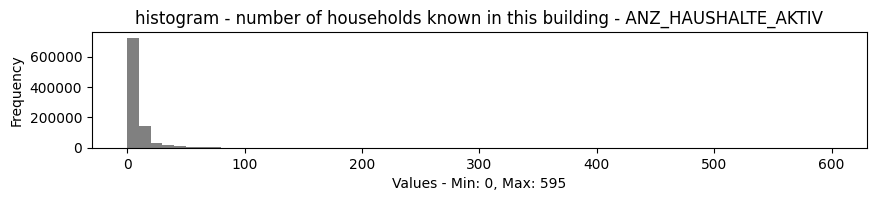

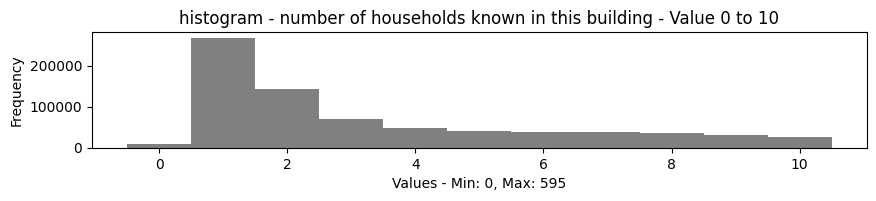

Outliers (Value: %)
595: 0.0%, 536: 0.0%, 523: 0.0%, 515: 0.0%, 445: 0.0%, 438: 0.0%, 430: 0.0%, 414: 0.0%, 404: 0.0%, 395: 0.0%
379: 0.0%, 378: 0.0%, 377: 0.0%, 367: 0.0%, 366: 0.0%, 353: 0.0%, 348: 0.0%, 347: 0.0%, 346: 0.0%, 344: 0.0%
333: 0.0%, 331: 0.0%, 328: 0.0%, 326: 0.0%, 321: 0.0%, 318: 0.0%, 317: 0.0%, 316: 0.0%, 314: 0.0%, 311: 0.0%
307: 0.0%, 305: 0.0%, 304: 0.0%, 301: 0.0%, 293: 0.0%, 290: 0.0%, 286: 0.0%, 285: 0.0%, 283: 0.0%, 280: 0.0%
277: 0.0%, 276: 0.0%, 274: 0.0%, 272: 0.0%, 267: 0.0%, 266: 0.0%, 265: 0.0%, 263: 0.0%, 260: 0.0%, 259: 0.0%
258: 0.0%, 256: 0.0%, 255: 0.0%, 254: 0.0%, 253: 0.0%, 252: 0.0%, 250: 0.0%, 249: 0.0%, 247: 0.0%, 246: 0.0%
244: 0.0%, 243: 0.0%, 242: 0.0%, 241: 0.0%, 240: 0.0%, 238: 0.0%, 237: 0.0%, 236: 0.0%, 232: 0.0%, 231: 0.0%
230: 0.0%, 229: 0.0%, 228: 0.0%, 226: 0.0%, 225: 0.0%, 224: 0.0%, 223: 0.0%, 222: 0.0%, 221: 0.0%, 220: 0.0%
219: 0.0%, 218: 0.0%, 216: 0.0%, 215: 0.0%, 214: 0.0%, 213: 0.0%, 211: 0.0%, 210: 0.0%, 209: 0.0%, 208: 0.0%

In [75]:
view_feature ('ANZ_HAUSHALTE_AKTIV')

In [76]:
p_process['3.2-ANZ_HAUSHALTE_AKTIV'] = '[Log scale]'

* ANZ_HH_TITEL  
  - No pre-processing needed: Value 0 and max value might be strange or extreme but are possible

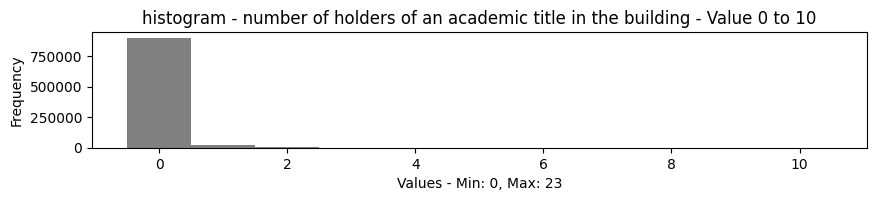

Outliers (Value: %)
23: 0.0%, 20: 0.0%, 18: 0.0%, 17: 0.0%, 16: 0.0%, 15: 0.0%, 14: 0.0%, 13: 0.0%, 12: 0.0%, 11: 0.0%
10: 0.0%, 9: 0.0%, 8: 0.0%, 7: 0.0%, 6: 0.0%, 5: 0.0%, 4: 0.0%, 3: 0.1%, 2: 0.3%, 1: 2.7%




In [77]:
view_feature ('ANZ_HH_TITEL', False)

* ANZ_PERSONEN  
  - Value 0: a household can not have 0 person, that Value 0 should be replaced to NaN
  - outliers: household with over 10 persons is highly extreme or data error, that Value over 10 should be replaced to NaN

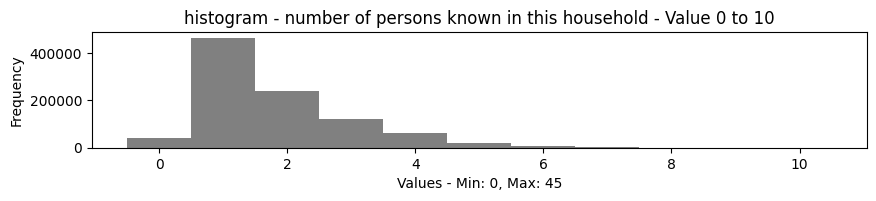

Outliers (Value: %)
45: 0.0%, 40: 0.0%, 38: 0.0%, 37: 0.0%, 35: 0.0%, 31: 0.0%, 29: 0.0%, 23: 0.0%, 22: 0.0%, 21: 0.0%
20: 0.0%, 18: 0.0%, 17: 0.0%, 16: 0.0%, 15: 0.0%, 14: 0.0%, 13: 0.0%, 12: 0.0%, 11: 0.0%, 10: 0.0%
9: 0.0%, 8: 0.1%, 7: 0.2%, 6: 0.7%, 5: 2.3%, 4: 6.6%




In [78]:
view_feature ('ANZ_PERSONEN', False)

In [79]:
p_process['3.2-ANZ_PERSONEN'] = 'replace Value 0 to NaN / Value > 10 to NaN'

* ANZ_STATISTISCHE_HAUSHALTE   
  - No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
  - Log scale is needed due to high skewness

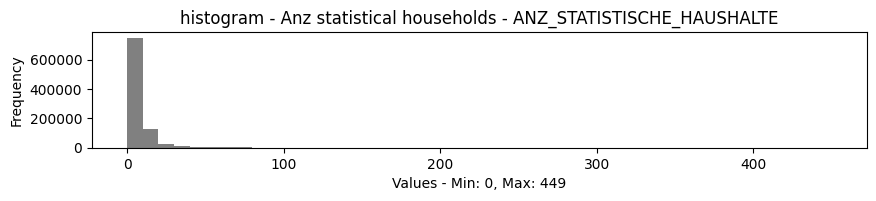

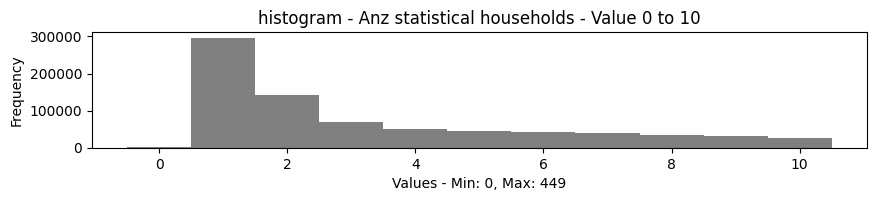

Outliers (Value: %)
449: 0.0%, 445: 0.0%, 375: 0.0%, 371: 0.0%, 369: 0.0%, 367: 0.0%, 366: 0.0%, 365: 0.0%, 354: 0.0%, 353: 0.0%
342: 0.0%, 339: 0.0%, 336: 0.0%, 328: 0.0%, 322: 0.0%, 319: 0.0%, 317: 0.0%, 314: 0.0%, 309: 0.0%, 304: 0.0%
303: 0.0%, 299: 0.0%, 297: 0.0%, 296: 0.0%, 292: 0.0%, 289: 0.0%, 286: 0.0%, 284: 0.0%, 274: 0.0%, 269: 0.0%
268: 0.0%, 264: 0.0%, 262: 0.0%, 258: 0.0%, 257: 0.0%, 256: 0.0%, 253: 0.0%, 252: 0.0%, 251: 0.0%, 248: 0.0%
245: 0.0%, 244: 0.0%, 243: 0.0%, 242: 0.0%, 241: 0.0%, 240: 0.0%, 239: 0.0%, 238: 0.0%, 237: 0.0%, 235: 0.0%
234: 0.0%, 233: 0.0%, 230: 0.0%, 229: 0.0%, 228: 0.0%, 227: 0.0%, 225: 0.0%, 223: 0.0%, 222: 0.0%, 218: 0.0%
217: 0.0%, 216: 0.0%, 214: 0.0%, 213: 0.0%, 212: 0.0%, 209: 0.0%, 205: 0.0%, 204: 0.0%, 203: 0.0%, 202: 0.0%
201: 0.0%, 200: 0.0%, 199: 0.0%, 198: 0.0%, 197: 0.0%, 195: 0.0%, 194: 0.0%, 193: 0.0%, 192: 0.0%, 190: 0.0%
189: 0.0%, 187: 0.0%, 186: 0.0%, 185: 0.0%, 184: 0.0%, 183: 0.0%, 182: 0.0%, 181: 0.0%, 180: 0.0%, 179: 0.0%

In [80]:
view_feature ('ANZ_STATISTISCHE_HAUSHALTE')

In [81]:
p_process['3.2-ANZ_STATISTISCHE_HAUSHALTE'] = '[Log scale]'

* ANZ_STATISTISCHE_HAUSHALTE   
  Value 0 and max value might be strange or extreme but are possible, but this feature is linked to ANZ_PERSONEN above
  - replace value to NaN if corresponding ANZ_PERSONEN is NaN

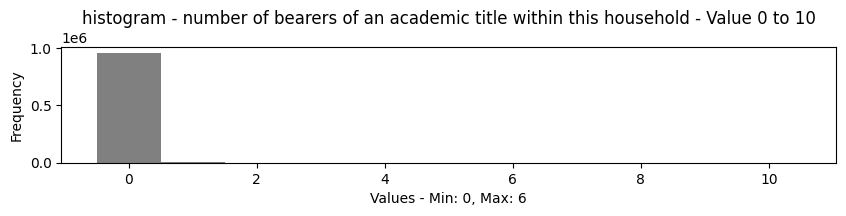

Outliers (Value: %)
6: 0.0%, 5: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0%, 1: 0.6%




In [82]:
view_feature ('ANZ_TITEL', False)

In [83]:
p_process['3.2-ANZ_TITEL'] = 'replace value to NaN if ANZ_PERSONEN is NaN'

* EINGEZOGENAM_HH_JAHR 
  - outliers: Eng translation is not completely understandable, but 3 outliers can be replaced to NaN 

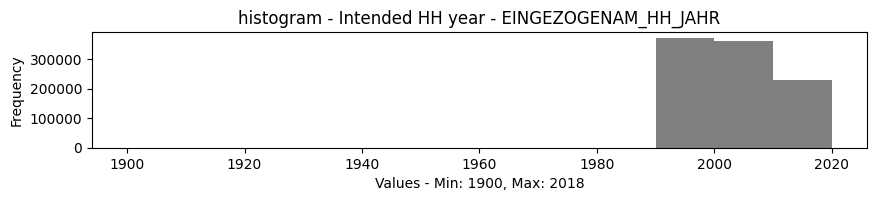

Outliers (Value: %)
1971: 0.0%, 1904: 0.0%, 1900: 0.0%




In [84]:
view_feature ('EINGEZOGENAM_HH_JAHR', True, False)

In [85]:
concat_numeric[concat_numeric['EINGEZOGENAM_HH_JAHR'] < 1980]['EINGEZOGENAM_HH_JAHR'].count()

3

In [86]:
p_process['3.2-AEINGEZOGENAM_HH_JAHR'] = 'replace Value < 1980 to NaN'

* EXTSEL992   
  - No pre-processing needed

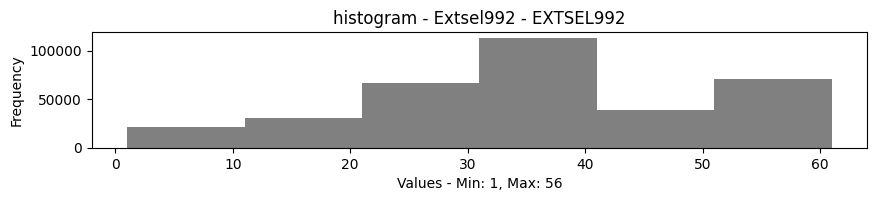

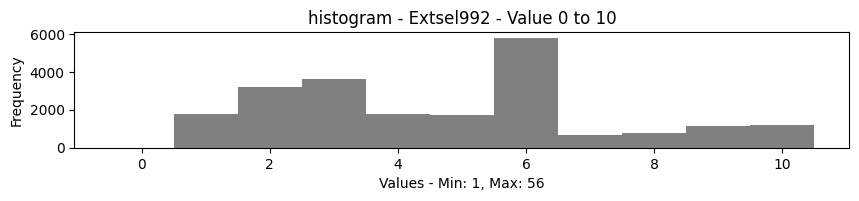

Outliers (Value: %)




In [87]:
view_feature ('EXTSEL992')

* GEBURTSJAHR  
  - outliers: birth year can not be 0, that Value < 1900 should be replaced to NaN

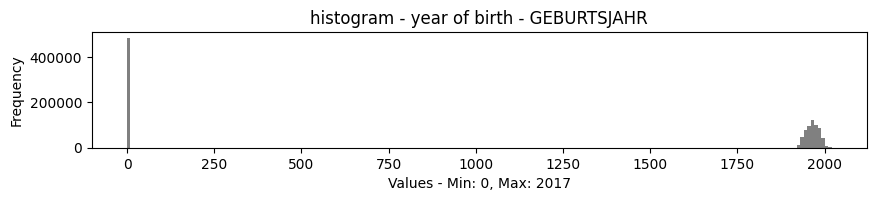

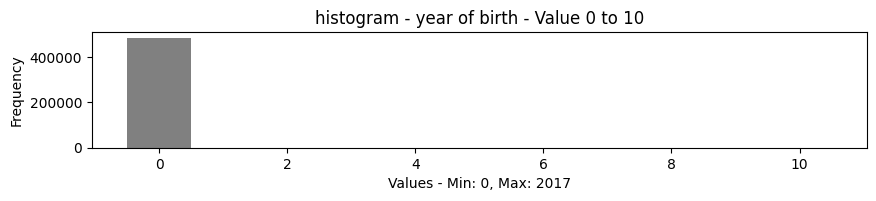

Outliers (Value: %)




In [88]:
view_feature ('GEBURTSJAHR')

In [89]:
p_process['3.2-GEBURTSJAHR'] = 'replace Value < 1900 to NaN'

* GEMEINDETYP   
  - No pre-processing needed

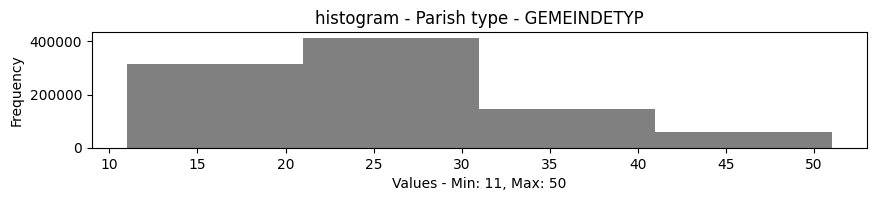

Outliers (Value: %)




In [90]:
view_feature ('GEMEINDETYP', True, False)

* KBA13_ANZAHL_PKW   
  - Log scale is needed due to high skewness as values over 1250 is grouped by 100

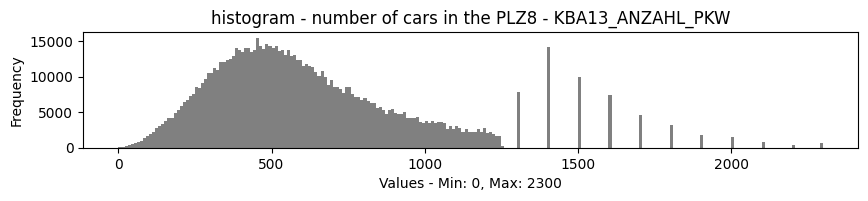

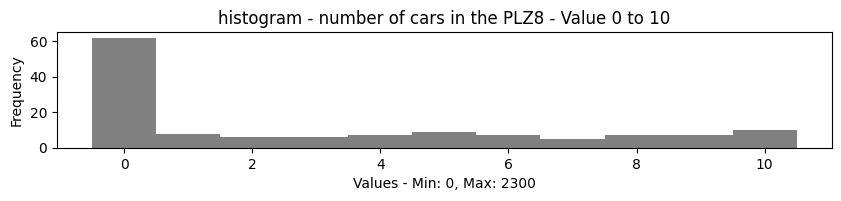

Outliers (Value: %)
2300: 0.1%, 2200: 0.0%, 2100: 0.1%, 2000: 0.2%, 1900: 0.2%, 1800: 0.3%, 1700: 0.5%, 1600: 0.8%, 1500: 1.1%, 1400: 1.5%




In [91]:
view_feature ('KBA13_ANZAHL_PKW')

In [92]:
p_process['3.2-KBA13_ANZAHL_PKW'] = '[Log scale]'

* MIN_GEBAEUDEJAHR   
  - No pre-processing needed

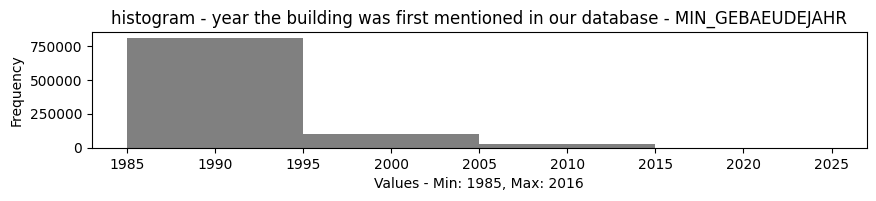

Outliers (Value: %)
2016: 0.0%, 2015: 0.1%, 2014: 0.1%, 2013: 0.2%, 2012: 0.2%, 2011: 0.2%, 2010: 0.2%, 2009: 0.2%, 2008: 0.3%, 2007: 0.3%
2006: 0.2%, 2005: 0.7%, 2004: 0.4%, 2003: 0.4%, 2002: 0.5%, 2001: 0.7%, 2000: 0.9%, 1999: 0.5%, 1998: 0.5%, 1997: 1.8%
1996: 2.0%, 1995: 3.0%, 1990: 0.6%, 1989: 0.3%, 1988: 0.1%, 1987: 0.1%, 1986: 0.0%, 1985: 0.0%




In [93]:
view_feature ('MIN_GEBAEUDEJAHR', True, False)

* VERDICHTUNGSRAUM   
  - No pre-processing needed with Eng translation not completely understandable

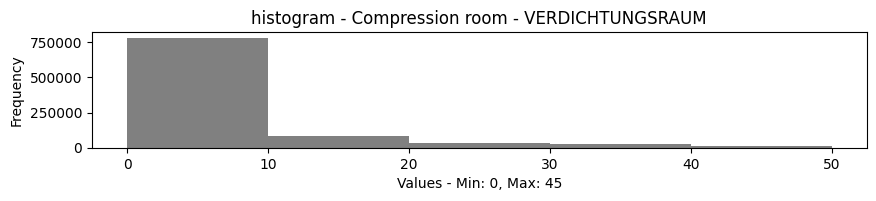

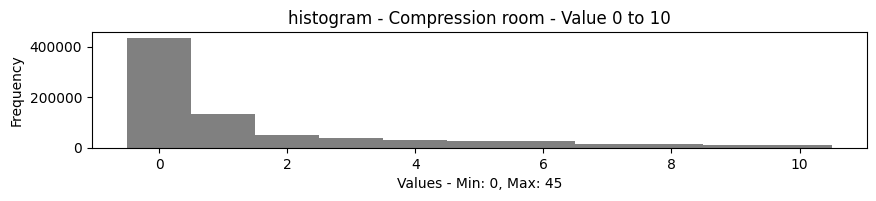

Outliers (Value: %)
45: 0.2%, 44: 0.2%, 43: 0.2%, 42: 0.2%, 41: 0.1%, 40: 0.2%, 39: 0.2%, 38: 0.2%, 37: 0.2%, 36: 0.3%
35: 0.2%, 34: 0.2%, 33: 0.4%, 32: 0.3%, 31: 0.3%, 30: 0.3%, 29: 0.3%, 28: 0.3%, 27: 0.4%, 26: 0.3%
25: 0.4%, 24: 0.5%, 23: 0.4%, 22: 0.4%, 21: 0.4%, 20: 0.4%, 19: 0.4%, 18: 0.7%, 17: 0.8%, 16: 0.8%
15: 0.8%, 14: 0.9%, 13: 1.0%




In [94]:
view_feature ('VERDICHTUNGSRAUM')

##### 3.3 str values

///// extract 8 features in str type

In [110]:
concat_string = concat_data.select_dtypes(exclude = ['int', 'float'])
concat_str = concat_string.copy()
concat_str.shape

(1082873, 8)

In [111]:
# extract summary of concat_string by applying describe and transpose
concat_summary = concat_str.describe().T.reset_index()

# merge Desc (information on Attribute) from feature_desc
concat_summary = concat_summary.rename(columns = {'index' : 'Attribute'})
concat_summary = vlookup(concat_summary, feature_desc, 'Attribute', 'Desc')
concat_summary

,Attribute,count,unique,top,freq,Desc
0,CAMEO_DEU_2015,933466,45,6B,66306,CAMEO_4.0: specific group
1,CAMEO_DEUG_2015,933466,19,8,87739,CAMEO_4.0: uppergroup
2,CAMEO_INTL_2015,933466,43,51,83563,CAMEO INTL 2015
3,D19_LETZTER_KAUF_BRANCHE,778063,35,D19_UNBEKANNT,227248,D19 Last purchase industry
4,EINGEFUEGT_AM,939798,5254,1992-02-10 00:00:00,448482,Finded on
5,OST_WEST_KZ,939798,2,W,759910,flag indicating the former GDR/FRG
6,PRODUCT_GROUP,191652,3,COSMETIC_AND_FOOD,100860,Product Group
7,CUSTOMER_GROUP,191652,2,MULTI_BUYER,132238,Customer Group


///// type EINGEFUEGT_AM should be changed to datetime with only year value to avoid excessively huge size

In [112]:
concat_str = concat_str.drop('EINGEFUEGT_AM', axis = 1)
p_process['3.3.2'] = 'change type of EINGEFUEGT_AM to datetime of year'

In [118]:
# extract values of Attribute in list
concat_str_values = pd.DataFrame(
    {'Attribute': concat_str.columns,
     'Score_val': concat_str.values.T.tolist()})
concat_str_values['Score_val'] = concat_str_values['Score_val'].apply(
    lambda x: list(pd.Series(x).drop_duplicates().dropna()))

# merge Desc (information on Attribute) from feature_desc and add min_max_cat
concat_str_values = vlookup(concat_str_values, feature_desc, 'Attribute', ['Desc', 'Additional notes'])

view_all(concat_str_values)

,Attribute,Score_val,Desc,Additional notes
0,CAMEO_DEU_2015,"[1A, 5D, 4C, 7B, 3B, 1D, 9E, 2D, 4A, 6B, 9D, 8B, 5C, 9C, 4E, 6C, 8C, 8A, 5B, 9B, 3D, 2A, 3C, 5F, 7A, 1E, 2C, 7C, 5A, 2B, 6D, 7E, 5E, 6E, 3A, 9A, 4B, 1C, 1B, 6A, 8D, 7D, 6F, 4D, XX]",CAMEO_4.0: specific group,NaN
1,CAMEO_DEUG_2015,"[1.0, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, 6, 3, 8, 9, 2, 4, 1, 7, 5, X]",CAMEO_4.0: uppergroup,New German CAMEO Typology established together with Call Credit in late 2015
2,CAMEO_INTL_2015,"[13.0, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0, 51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0, 45, 25, 55, 51, 14, 54, 43, 22, 15, 24, 35, 23, 12, 44, 41, 52, 31, 13, 34, 32, 33, XX]",CAMEO INTL 2015,NaN
3,D19_LETZTER_KAUF_BRANCHE,"[D19_UNBEKANNT, D19_BANKEN_GROSS, D19_NAHRUNGSERGAENZUNG, D19_SCHUHE, D19_BUCH_CD, D19_DROGERIEARTIKEL, D19_SONSTIGE, D19_TECHNIK, D19_VERSICHERUNGEN, D19_TELKO_MOBILE, D19_VOLLSORTIMENT, D19_HAUS_DEKO, D19_ENERGIE, D19_REISEN, D19_BANKEN_LOKAL, D19_VERSAND_REST, D19_BEKLEIDUNG_REST, D19_FREIZEIT, D19_BEKLEIDUNG_GEH, D19_TELKO_REST, D19_SAMMELARTIKEL, D19_BANKEN_DIREKT, D19_KINDERARTIKEL, D19_BANKEN_REST, D19_LEBENSMITTEL, D19_GARTEN, D19_HANDWERK, D19_RATGEBER, D19_DIGIT_SERV, D19_BIO_OEKO, D19_BILDUNG, D19_WEIN_FEINKOST, D19_TIERARTIKEL, D19_LOTTO, D19_KOSMETIK]",D19 Last purchase industry,NaN
4,OST_WEST_KZ,"[W, O]",flag indicating the former GDR/FRG,NaN
5,PRODUCT_GROUP,"[COSMETIC_AND_FOOD, FOOD, COSMETIC]",Product Group,NaN
6,CUSTOMER_GROUP,"[MULTI_BUYER, SINGLE_BUYER]",Customer Group,NaN


**그냥 여기서 보고 처리하는 것이 나을 듯**

In [117]:
pv_attr_str_compare = pd.DataFrame(pv_attr_str.to_records())

,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ALTERSKATEGORIE_GROB,age classification through prename analysis,age through prename analysis,modelled on millions of first name-age-referen...,[unknown],"[-1, 0]"
1,ANREDE_KZ,gender,gender,no_info,[unknown],"[-1, 0]"
2,ANZ_HAUSHALTE_AKTIV,number of households in the building number of...,number of households known in this building,no_info,[numeric value (typically coded from 1-10)],[…]
3,ANZ_HH_TITEL,number of academic title holder in building nu...,number of holders of an academic title in the ...,no_info,[numeric value (typically coded from 1-10)],[…]
4,ANZ_PERSONEN,number of adult persons in the household numbe...,number of persons known in this household,no_info,[numeric value (typically coded from 1-3)],[…]
...,...,...,...,...,...,...
93,SEMIO_VERT,affinity indicating in what way the person is ...,affinity indicating in what way the person is ...,no_info,[unknown],"[-1, 9]"
94,TITEL_KZ,flag whether this person holds an academic title,flag whether this person holds an academic title,no_info,[unknown],"[-1, 0]"
95,WOHNDAUER_2008,length of residence,length of residenca,no_info,[unknown],"[-1, 0]"
96,W_KEIT_KIND_HH,likelihood of a child present in this household,likelihood of a child present in this househol...,no_info,[unknown],"[-1, 0]"


In [123]:
pv_attr_str_compare = pv_attr_str
concat_str_compare = vlookup(concat_str_values, pv_attr_str_compare, 'Attribute', 'Score', 'not_in_attr')
concat_str_compare

,Attribute,Score_val,Desc,Additional notes,Score
0,CAMEO_DEU_2015,"[1A, 5D, 4C, 7B, 3B, 1D, 9E, 2D, 4A, 6B, 9D, 8...",CAMEO_4.0: specific group,NaN,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3..."
1,CAMEO_DEUG_2015,"[1.0, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, ...",CAMEO_4.0: uppergroup,New German CAMEO Typology established together...,not_in_ref_file
2,CAMEO_INTL_2015,"[13.0, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14....",CAMEO INTL 2015,NaN,not_in_ref_file
3,D19_LETZTER_KAUF_BRANCHE,"[D19_UNBEKANNT, D19_BANKEN_GROSS, D19_NAHRUNGS...",D19 Last purchase industry,NaN,not_in_ref_file
4,OST_WEST_KZ,"[W, O]",flag indicating the former GDR/FRG,NaN,"[O, W]"
5,PRODUCT_GROUP,"[COSMETIC_AND_FOOD, FOOD, COSMETIC]",Product Group,NaN,not_in_ref_file
6,CUSTOMER_GROUP,"[MULTI_BUYER, SINGLE_BUYER]",Customer Group,NaN,not_in_ref_file


In [124]:
view_all(concat_str_compare)

,Attribute,Score_val,Desc,Additional notes,Score
0,CAMEO_DEU_2015,"[1A, 5D, 4C, 7B, 3B, 1D, 9E, 2D, 4A, 6B, 9D, 8B, 5C, 9C, 4E, 6C, 8C, 8A, 5B, 9B, 3D, 2A, 3C, 5F, 7A, 1E, 2C, 7C, 5A, 2B, 6D, 7E, 5E, 6E, 3A, 9A, 4B, 1C, 1B, 6A, 8D, 7D, 6F, 4D, XX]",CAMEO_4.0: specific group,NaN,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3C, 3D, 4A, 4B, 4C, 4D, 4E, 5A, 5B, 5C, 5D, 5E, 5F, 6A, 6B, 6C, 6D, 6E, 6F, 7A, 7B, 7C, 7D, 7E, 8A, 8B, 8C, 8D, 9A, 9B, 9C, 9D, 9E]"
1,CAMEO_DEUG_2015,"[1.0, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, 6, 3, 8, 9, 2, 4, 1, 7, 5, X]",CAMEO_4.0: uppergroup,New German CAMEO Typology established together with Call Credit in late 2015,not_in_ref_file
2,CAMEO_INTL_2015,"[13.0, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0, 51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0, 45, 25, 55, 51, 14, 54, 43, 22, 15, 24, 35, 23, 12, 44, 41, 52, 31, 13, 34, 32, 33, XX]",CAMEO INTL 2015,NaN,not_in_ref_file
3,D19_LETZTER_KAUF_BRANCHE,"[D19_UNBEKANNT, D19_BANKEN_GROSS, D19_NAHRUNGSERGAENZUNG, D19_SCHUHE, D19_BUCH_CD, D19_DROGERIEARTIKEL, D19_SONSTIGE, D19_TECHNIK, D19_VERSICHERUNGEN, D19_TELKO_MOBILE, D19_VOLLSORTIMENT, D19_HAUS_DEKO, D19_ENERGIE, D19_REISEN, D19_BANKEN_LOKAL, D19_VERSAND_REST, D19_BEKLEIDUNG_REST, D19_FREIZEIT, D19_BEKLEIDUNG_GEH, D19_TELKO_REST, D19_SAMMELARTIKEL, D19_BANKEN_DIREKT, D19_KINDERARTIKEL, D19_BANKEN_REST, D19_LEBENSMITTEL, D19_GARTEN, D19_HANDWERK, D19_RATGEBER, D19_DIGIT_SERV, D19_BIO_OEKO, D19_BILDUNG, D19_WEIN_FEINKOST, D19_TIERARTIKEL, D19_LOTTO, D19_KOSMETIK]",D19 Last purchase industry,NaN,not_in_ref_file
4,OST_WEST_KZ,"[W, O]",flag indicating the former GDR/FRG,NaN,"[O, W]"
5,PRODUCT_GROUP,"[COSMETIC_AND_FOOD, FOOD, COSMETIC]",Product Group,NaN,not_in_ref_file
6,CUSTOMER_GROUP,"[MULTI_BUYER, SINGLE_BUYER]",Customer Group,NaN,not_in_ref_file


In [130]:
attr_num[attr_num['Attribute'] == 'CUSTOMER_GROUP']

,Attribute,Description,Score,Meaning,Score_form


In [138]:
concat_str_compare[concat_str_compare['Attribute'] == 'CAMEO_DEU_2015']['Score_val'].values

array([list(['1A', '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B', '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D', '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E', '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F', '4D', 'XX'])],
      dtype=object)

**23.05.31**

In [122]:
concat_str_compare['Score_compare'] = [list(a - b) for a, b in zip(
    concat_str_compare['Score_val'], concat_str_compare['Score'])]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:
concat_numeric = concat_data.select_dtypes(include = ['int', 'float']).copy()
concat_num = concat_numeric.copy()
concat_num.shape

(1082873, 361)

///// And concat_num with the summary statistics is formed.

In [ ]:
# extract summary statistics of concat_numeric by applying describe and transpose
concat_stat = concat_num.describe().T.reset_index()

# merge Desc (information on Attribute) from feature_desc and add min_max_cat
concat_stat = concat_stat.rename(columns = {'index' : 'Attribute'})
concat_stat = vlookup(concat_stat, feature_desc, 'Attribute', 'Desc')
concat_stat['min_max_cat'] = concat_stat[
    'min'].apply(lambda x: '{:_.0f}'.format(x)).astype(str) + ' to ' + concat_stat[
    'max'].apply(lambda x: '{:_.0f}'.format(x)).astype(str)

concat_stat.head()

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,min_max_cat
0,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,1 to 1_082_873
1,AGER_TYP,1082873.0,-0.234051,1.263860,-1.0,-1.0,-1.0,1.0,3.0,best-ager typology,-1 to 3
2,AKT_DAT_KL,962778.0,4.018992,3.569841,1.0,1.0,1.0,9.0,9.0,Act Dat KL,1 to 9
3,ALTER_HH,962778.0,10.937633,7.452130,0.0,0.0,13.0,17.0,21.0,main age within the household,0 to 21
4,ALTER_KIND1,92824.0,11.820413,4.090882,2.0,8.0,12.0,15.0,18.0,Old child1,2 to 18


In [ ]:
p_process['3.3.2-XX'] = 'replace Value X, XX to NaN'

### 4. Pre-processing

In [ ]:
p_process = {'pre_processing_itmes' : p_process}
p_process_items = pd.DataFrame(p_process).reset_index()
p_process_items

**그 다음에 Preprocessing을 하고 나면 (필요시 극히 비슷한 컬럼 제외),   
Imputing, Scaling 하면 PCA, Clustering, 앙상블로 나갈 수 있음** 

# **STOP**

In [ ]:
stop

[function] miss_val_summary

In [ ]:
def miss_val_summary(df, axis_val, x_bin = 2, bar_chart = True):
    '''
    function to display summary, bar-chart (optional) and histogram
    of missing value by column or raw
    df: dataframe
    axis_val: str, one of 'column' or 'row'
    x_bin: size of x bin, 10 as default
    bar_chart: option of bar chart display 
    '''
    # index of axis
    axis_idx = 0 if axis_val == 'column' else 1
    
    # % of missing values
    missing_pct = df.isnull().mean(axis = axis_idx) * 100
    df_desc = missing_pct.describe()

    # summary of missing value
    print (
        '% of missing value in ' + str(int(df_desc[0])) + ' ' + axis_val + 's of ' + df.name)
    print (df_desc[1:].to_string())
    
    # bar-chart of missing value
    if bar_chart:
        missing_pct.plot(
            kind = 'bar', figsize=(10, 3), color='gray',
            
            title = ('bar chart - ' + df.name + ': missing value by ' + axis_val),
            ylabel = '% of missing value',
            xlabel = (str(int(df_desc[0])) + ' columns'),
            xticks = [],
            );
        plt.show()
    
    # hist of missing value
    x_range = ((df_desc[-1] + 10) // 10) * 10 + x_bin
    ax = missing_pct.plot(
        kind = 'hist', figsize=(10, 3), color='gray',
        
        bins = np.arange(0, x_range, x_bin),
        title = ('histogram - ' + df.name + ': missing value by ' + axis_val)
        )
    ax.set_xlabel('% of missing value');
    plt.show()

In [ ]:
'''
missing value by columns of azdias
'''

miss_val_summary(azdias, 'column')

In [ ]:
'''
missing value by column
'''

miss_val_summary(customers, 'column')

#### 1.5 alignment of features   
as values of data files (azdias & customers) can be readable by explanations of information files (info & attr),   
check alignment in column features of data files and equivalent values of column Attribute of information files at first   

> 합쳐서 데이터 분석시 참조
> 93 데이터에만 있는 Attr은 어떻게 할 것인가?
> 데이터 파일에 없고 정보 파일에만 있는 51 Attr은 제외하여 simplify 함

### 2. Data exploration

#### 2.1 feature description
As the data sets do not have information on what each feature (column name) exactly means,   
values of information files (info & attr) should be mapped to the features at first,   
to see how the data sets are structured.

In [ ]:
'''
to know what features datasets have, add information to column names of customers
'''

feature_desc = pd.DataFrame(customers.columns, columns=['Attribute'])
feature_desc = vlookup(feature_desc, info, 'Attribute')

'''
df_feature has 369 unique Attribute values:
105 exclusive values of customers and 264 shared values with customers
(see 1.5 alignment of features)
''' 
print ('Attributes missing Description:', feature_desc[feature_desc.Description.isna()].shape[0])
print (feature_desc.shape)
feature_desc.head()

In [ ]:
'''
To enhance readability of data set - over 100 features are without description -   
I added 14 Description values from attr, and made a column of translation   
(ger_to_eng) to df_feature using code below.
However as this code-running takes somewhat long time, I saved the dataframe processed
as df_feature.xlsx in root folder
'''

# # For values of Attribute without Description, add 14 Description values from attr
# df_feature.set_index('Attribute', inplace = True)

# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# df_feature.update(attr_excl)

# df_feature.reset_index(inplace = True)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# df_feature['ger_to_eng'] = np.where(
#     df_feature.Description.isnull(),
#     df_feature.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# df_feature['Desc'] = df_feature.Description.fillna('') + df_feature.ger_to_eng.fillna('')

feature_desc = pd.read_excel('feature_desc.xlsx', index_col = [0])
feature_desc.head(10)

print ('Attributes missing Desc:', feature_desc[feature_desc.Desc.isna()].shape[0])
print (feature_desc.shape)
feature_desc.head()

In [ ]:
'''
find all features one by one
'''

# # not to run

# view_all(feature_desc)

In [ ]:
list(set(attr.Attribute.unique()) - set(feature_desc.Attribute.unique()))

In [ ]:
diff = (list(set(attr.Attribute.unique()) - set(feature_desc.Attribute.unique())))
len(diff)

In [ ]:
short_df = attr.iloc[:, :2].drop_duplicates()

In [ ]:
short_df[short_df.Attribute.isin(diff)]

In [ ]:
attr[attr.iloc[:, :2].drop_duplicates().Attribute.isin(diff)]

> 살펴 봤음. 모든 Attribute에 대해서 Description을 completely 이해할 수는 없었으나   
> 대체적인 내용 구성을 이해할 수는 있었음   
> 비슷한 내용을 나타내는 중복열, 유사열이 많아 공선성 해소, 차원 축소가 필요함

#### 2.2 data values
The values of the data sets can also be readable by mapping values of Value and Meaning of attr.   
In this section, 데이터 종류 (연속/이산), 이상치, 사실상의 null value 등 데이터 전처리를 위한 데이터의 내용적 측면을 점검하겠음.     

In [ ]:
'''
check types of values of attr Value, which contains information on data values
'''

attr['Value_dtype'] = attr.Value.map(type)
print (attr.Value_dtype.value_counts())

# attr['Meaning_dtype'] = attr.Meaning.map(type)
# print (attr.Meaning_dtype.value_counts())

##### 2.2.1 attr의 int 데이터

1.5에서 살펴본 바와 같이 272개 피쳐는 attr을 통해 설명이 가능함 (물론 이것도 데이터를 따로 파악해 봐야 하나)    
데이터 셋을 직접 살펴 보는 것은 뒤에 별도록 진행하고 우선 attr을 분석하여 데이터 내용이 어떻게 구성되어 있는지 Basis를 확보해야 함.   

2113개의 정수 값이고, 145개는 object로 정수 값으로 정의된 value를 먼저 점검해 보겠음.

* numeric data of column Value

In [ ]:
'''
numeric data of column Value
'''
# attr_num with only numeric values in Value
attr_num = attr[attr['Value_dtype'] == int].copy()
print (attr_num.shape) 

# add Desc and Information level
attr_num = vlookup(attr_num, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
print (attr_num.info())
attr_num.head()

In [ ]:
'''
customers에는 없고 attr에만 있는 42개 Attribute는 Desc가 없으으로
(1.5 alignment) desc가 null이 아닌 행만 keep
'''

print ('customers에는 없고 attr에만 있는 42개 Attribute 수:', 
       attr_num[attr_num.Desc.isna() == True].Attribute.nunique(),
       '\n')

attr_num = attr_num[attr_num.Desc.isna() == False]
print (attr_num.info())

In [ ]:
'''
numeric data of column Value where 1774 rows have data in int type 으로
pivot을 돌려 int type Value가 어떤 min max 값을 가지는 지 정리함.
이를 통해 각 feature의 data type을 추정하고, 효과적으로 비정상 값을 찾아내려 함
'''

# summary of numeric data of Value
pv_attr_num = pd.pivot_table(
    attr_num,
    index = ['Attribute', 'Desc'],
    values = 'Value',
    aggfunc = [min, max]
    )

pv_attr_num['min_max_cat'] = pv_attr_num['min'].astype(str) + ' to ' + pv_attr_num['max'].astype(str)
pv_attr_num = pv_attr_num.sort_values(by = 'min_max_cat')

print (
    'min_max category of numeric data in column Value', '\n',
    pv_attr_num.min_max_cat.value_counts())
pv_attr_num.head()

In [ ]:
'''
find all numeric data of column Value one by one
'''

# # not to run

# with pd.option_context(
#     'display.max_rows', None, 'display.max_colwidth', None):
#     display(pv_attr_num)

> 1. value -1, 0의 경우 null 또는 -inf에 상응하는 데이터가 있는지  
> 2. max가 7까지는 descrete, 8 이상은 continue 인지 봐야하고 Max의 null 또는 -inf에 상응하는 데이터가 있는지
> 3. binary cells

In [ ]:
'''
1. value -1, 0의 경우 null 또는 -inf에 상응하는 데이터가 있는지 
'''
attr_below_1 = attr_num[attr_num.Value < 1]
print(attr_below_1.shape)
attr_below_1.Meaning.unique()

In [ ]:
'''
위 값 중 null 가능성이 있는 값만 추려 본결과
'''

maybe_null = ['unknown',
              'no classification possible',
              'unknown / no main age detectable',
              'no transactions known', 
              'no transaction known', 
              'classification not possible',
              'none',
              'no score calculated'
              ]

attr_below_1 = attr_below_1[attr_below_1.Meaning.isin(maybe_null)].sort_values(by = 'Meaning')
print(attr_below_1.shape)
attr_below_1

In [ ]:
# # not to run

# view_all(attr_below_1)

> Meaning이 maybe_null 이면 모두 nan 처리

In [ ]:
'''
2. max가 7까지는 descrete, 8 이상은 continue 인지 봐야하고 Max의 null 또는 -inf에 상응하는 데이터가 있는지
'''

# pv_attr_num에서 max가 7보다 큰 Attr을 추출함
max_over_7_Attr = pv_attr_num[pv_attr_num[('max', 'Value')] > 7].index.get_level_values(0)
# view_all(attr_num[attr_num.Attribute.isin(max_over_7_Attr)])
max_over_7 = attr_num[attr_num.Attribute.isin(max_over_7_Attr)]
pv_max_over_7 = pd.pivot_table(
    max_over_7,
    index = 'Attribute',
    values = 'Meaning',
    aggfunc = lambda x: list(x)
    )

In [ ]:
view_all(pv_max_over_7)

> no continuous data detected, 그러나 최대값에 maybe null이 보임

In [ ]:
max_over_7['Value'] = pd.to_numeric(max_over_7['Value'], errors='coerce')

max_over_7_idxmax = max_over_7.groupby('Attribute')['Value'].idxmax()

max_over_7.loc[max_over_7_idxmax, 'Meaning'].unique()

> maybe_null에 'uniformly distributed', ... 추가

In [ ]:
''' 
3. binary cells
'''

# pv_attr_num에서 max가 4보다 작은 Attr을 추출함
max_under_4_Attr = pv_attr_num[pv_attr_num[('max', 'Value')] < 4].index.get_level_values(0)
# view_all(attr_num[attr_num.Attribute.isin(max_over_7_Attr)])
max_under_4 = attr_num[attr_num.Attribute.isin(max_under_4_Attr)]
pv_max_under_4 = pd.pivot_table(
    max_under_4,
    index = 'Attribute',
    values = 'Meaning',
    aggfunc = lambda x: list(x)
    )

In [ ]:
view_all(pv_max_under_4)

> 뭐뭐뭐가 이진으로 전처리

##### 2.2.2 attr의 str 데이터

In [ ]:
'''
str data of column Value
'''
# attr_num with only numeric values in Value
attr_str = attr[attr['Value_dtype'] == str].copy()
print (attr_str.shape) 

# add Desc and Information level
attr_str = vlookup(attr_str, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
print (attr_str.info())
attr_str.head()

In [ ]:
# attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

In [ ]:
'''
3개 null attribute는 정수와 문자를 모두 값을로 갖는 것들로 42개는 유효하고
이 42개는 다음 section에서 볼 예정이므로 (1.5 alignment) desc가 null이 아닌 행만 keep
'''

# attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

attr_str = attr_str[attr_str.Desc.isna() == False]
print (attr_str.info())

In [ ]:
'''
pivot을 돌려 attribute 별로 어떤 str 값을 가지는 지 정리함.
이를 통해 각 feature의 data type을 추정하고, 효과적으로 비정상 값을 찾아내려 함
'''

pv_attr_str = pd.pivot_table(
    attr_str,
    index = ['Attribute', 'Desc', 'Meaning'],
    values = 'Value',
    aggfunc = lambda x: x
    )

pv_attr_str.head(10)
# view_all(pv_attr_str)

> 1. unknown을 표현하는 경우, drop에 포함    
> 2. 연속형 수치를 표현하는 경우 ... 이는 data set을 직접 보고 파악해야 함

In [ ]:
'''
순수하게 str인 경우만 추출
'''
# pv_attr_str = pd.DataFrame(pv_attr_str.to_records())

In [ ]:
# attr_str_to_check = pv_attr_str[pv_attr_str.Meaning.str.contains('numeric value')].Attribute
attr_str_to_check = pv_attr_str[
    pv_attr_str.index.get_level_values(2).str.contains('numeric value')].index.get_level_values(0)
# 먼저 추후 체크할 것들을 뽑아 놓고
attr_str_to_check

In [ ]:
pv_attr_str = pd.DataFrame(pv_attr_str[
    ~(pv_attr_str.index.get_level_values(0).isin(attr_str_to_check))
    &~(pv_attr_str.index.get_level_values(2) == 'unknown')
    ].to_records())

pv_attr_str = pd.pivot_table(
    pv_attr_str,
    index = ['Attribute', 'Desc'],
    values = 'Value',
    aggfunc = lambda x: list(x)
    )

view_all(pv_attr_str)

> CAMEO_DEU_2015 정상적인 카테고리 데이터... 피쳐   
> OST_WEST_KZ은 2진

##### 2.2.3 customers에만 있는 데이터

**상당히 해깔리게 되어 있는데, 데이터의 컬럼과 정보 파일의 Attribute 숫자를 좀 정확하게 정리하고   
하던데로 커스터머에만 있는 데이터를 정리하면 Wrangling이 끝남** 

**그 다음에 Preprocessing을 하고 나면 (필요시 극히 비슷한 컬럼 제외),   
Imputing, Scaling 하면 PCA, Clustering, 앙상블로 나갈 수 있음** 

#### 2-1. attributes_xlsx

In [ ]:
col_val(attributes_xlsx)

In [ ]:
w_list = list(attributes_xlsx.Meaning.unique())

In [ ]:
nltk.download('wordnet')

In [ ]:
ambiguous_words = []

for synset in w_list:
    if len(synset.lemmas()) > 1:
        ambiguous_words.append(synset.name().split('.')[0])

In [ ]:
list(wordnet.all_synsets())

In [ ]:
synsets = wordnet.synsets('unknown')
synsets

In [ ]:
synonyms = []

for synset in synsets:
    for lemma in synset.lemmas():
        synonyms.append(lemma.name())
synonyms

In [ ]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

# Define the target word
target_word = 'unidentified'

# Retrieve synsets for the target word
synsets = wordnet.synsets(target_word)

# # Retrieve synonyms for each synset and filter out synonyms containing the target word
# filtered_synonyms = []

# for synset in synsets:
#     synonyms = synset.lemmas()
#     filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

# # Remove duplicate synonyms and sort the list
# filtered_synonyms = sorted(set(filtered_synonyms))

# print(filtered_synonyms)

In [ ]:
filtered_synonyms = []

for synset in synsets:
    synonyms = synset.lemmas()
    filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

# Remove duplicate synonyms and sort the list
filtered_synonyms = sorted(set(filtered_synonyms))

print(filtered_synonyms)

In [ ]:
for target_word in filtered_synonyms:
    # # Define the target word
    # target_word = 'unidentified'

    # Retrieve synsets for the target word
    synsets = wordnet.synsets(target_word)

    for synset in synsets:
        synonyms = synset.lemmas()
        filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

    # Remove duplicate synonyms and sort the list
    filtered_synonyms = sorted(set(filtered_synonyms))

print(filtered_synonyms)

In [ ]:
# customers

print (customers.info())
customers.head()

In [ ]:
# attributes_xlsx

print (attributes_xlsx.info())
attributes_xlsx.head(10)

In [ ]:
# modify attributes_xlsx

attributes_xlsx = attributes_xlsx.iloc[:, 1:] # 1st column has no info
attributes_xlsx[['Attribute', 'Description']] = attributes_xlsx[
    ['Attribute', 'Description']].fillna(method = 'ffill')
print (attributes_xlsx.info())
attributes_xlsx.head(10)

In [ ]:
# information_xlsx

print (information_xlsx.info())
information_xlsx.head()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

Work / Ref

In [ ]:
# def col_val (df):
#     '''
#     function to check values of dataframe columns
#     df : dataframe
#     '''
#     # for i in df.columns:
#     #     print (i, '-', df[i].nunique(), 'values', '\n',
#     #         df[i].value_counts(), '\n', '*     *     *')
#     for i in df.columns:
#         print (i, '-', df[i].nunique(), 'values', '\n',
#         list(df[i].unique()), '\n', '*     *     *')

In [ ]:
# # from googletrans import Translator

# # Create an instance of the Translator
# translator = Translator(service_urls=['translate.google.com'])

# # Text to be translated
# text = "AGER_TYP"

# # Translate the text from German to English
# translation = translator.translate(text, src='de', dest='en')

# # Print the translated text
# print("Original text (German):", text)
# print("Translated text (English):", translation.text)

In [ ]:
# def miss_val_hist(df, axis_val, x_bin = 10):
#     '''
#     function to display missing value histogram by column or raw
#     df: dataframe
#     axis_val: str, one of 'column' or 'row'
#     x_bin: size of xtick bin, 10 as default 
#     '''
#     # axis value
#     axis_num = 0 if axis_val == 'column' else 1
    
#     # % of missing values
#     missing_pct = df.isnull().mean(axis = axis_num) * 100

#     # max % of missing values by column
#     missing_pct_max = missing_pct.max()
#     print ('max % of missing values by ' + axis_val + ': ', missing_pct_max)

#     # plot missing values by column
    
#     print (missing_pct.describe())
    
#     x_range = ((missing_pct_max + x_bin * 2) // x_bin) * x_bin

#     ax = missing_pct.plot(
#         kind = 'hist', figsize=(10, 3), color='gray',
#         bins = np.arange(0, x_range, 10),
#         title = (df.name + ': missing value by ' + axis_val)
#         )
#     ax.set_xlabel('% of missing value');

In [ ]:
# 파이써닉 하지 못한 코드
# # missing value overview
# for i in range(0, ((azdias.shape[1] + 100) // 100) * 100, 100):
#     msno.matrix(azdias.iloc[:, i : i + 99],
#                 figsize=(10, 3), fontsize = 12, labels = False, sparkline = False)
#     plt.title('missing value overview: col ' + str (i) + ' to ' + str (min(i + 99, azdias.shape[1] - 1)),
#               fontsize = 12);

In [ ]:
# # % of columns with missing values of over 30%
# (azdias.isnull().mean() * 100 > 30).mean()

In [ ]:
# # % of columns with missing values of 25% to 30%
# ((azdias.isnull().mean() * 100 > 25) & (30 >= azdias.isnull().mean() * 100)).mean()

In [ ]:
# 아마도 쓰지 않을 plot
# plot = azdias_col_missing_pct.plot(
#     kind = 'bar', figsize=(10, 3), color='dimgray', xticks = [],
#     title = 'azdias_col_missing_pct',
#     xlabel = '366 columns',
#     ylabel = '% of missing values')

In [ ]:
# num_df = customers.select_dtypes(include=['float', 'int64']).iloc[:, 1:]
# num_df.head()

In [ ]:
# len(pd.unique(customers.select_dtypes(include='float').values.flatten()).tolist())

In [ ]:
# with pd.option_context(
#     'display.max_rows', None, 'display.max_colwidth', None):
#     display(pd.DataFrame(attr.apply(lambda x: x.unique())))

In [ ]:
# attr_not_null = ~(attr.Attribute.isna())
# attr.loc[attr_not_null, 'Description'] = attr.loc[
#     attr_not_null, 'Description'] + ' ' + attr.loc[attr_not_null, 'desc_shift']

# desc_to_null = (attr.Attribute.isna()) & ~(attr.Description.isna())
# attr.loc[desc_to_null, 'Description'] = np.nan
# attr = attr.drop(columns = 'desc_shift')
# attr.loc[attr_with_value.shift(-1, fill_value = True), 'Description']
# attr_shift = attr_null.shift
# attr[attr_null.shift, 'Description'] = attr.loc[
#     attr_null.shift(fill_value = False), 'Description'] + ' ' + attr[attr_null, 'Description']

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# info_mg = info_mg.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
# # attr_excl = attr[attr.Attribute.isin(attr_excl)].copy()
# attr_not_null = attr.dropna(subset = 'Attribute').copy()
# attr_not_null = attr_not_null.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

# info_mg = pd.concat(
#     [info_mg, attr_not_null[['Attribute', 'Description']]],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# attr_excl = attr[attr.Attribute.isin(attr_excl)][['Attribute', 'Description']].copy()

# info_mg = pd.concat(
#     [info_mg, attr_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# # info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# view_all(info_mg)

In [ ]:
# '''
# to 2258 rows of Attribute in attr, add 13 values exclusively in info,
# and remove 52 values exclusively in information files
# '''

# attr_mg = attr.copy()
# info_excl = info[info.Attribute.isin(info_excl)][['Attribute', 'Description']].copy()
# info_excl['Value'] = 'form info'
# info_excl['Meaning'] = 'form info'

# attr_mg = pd.concat(
#     [attr_mg, info_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# # info_mg = info_mg.drop_duplicates()

# # info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(attr_mg.info())
# attr_mg.head()

In [ ]:
# attr_mg.tail(30)

In [ ]:
# '''
# there are 93 and 51 exclusive values in data and information files
# '''

# datafile_Attr = azdias_Attr.union(customers_Attr)
# infofile_Attr = info_Attr.union(attr_Attr)

# datafile_excl = datafile_Attr - infofile_Attr
# infofile_excl = infofile_Attr - datafile_Attr

# print (len(datafile_excl), 'Attribute value(s) exclusively in data files:',
#        '\n', datafile_excl)
# print (len(infofile_excl), 'Attribute value(s) exclusively in information files:',
#        '\n', infofile_excl)

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# info['Information level'] = info['Information level'].fillna(method = 'ffill')

# info.head()

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# attr[['Attribute', 'Description']] = attr[
#     ['Attribute', 'Description']].fillna(method = 'ffill')

# attr.head(10)

In [ ]:
# '''
# To enhance readability of data set - over 100 features are without description -   
# I added 14 Description values from attr, and made a column of translation   
# (ger_to_eng) to df_feature using code below.
# However as this code-running takes somewhat long time, I saved the dataframe processed
# as df_feature.xlsx in root folder
# '''

# # For values of Attribute without Description, add 14 Description values from attr
# df_feature.set_index('Attribute', inplace = True)

# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# df_feature.update(attr_excl)

# df_feature.reset_index(inplace = True)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# df_feature['ger_to_eng'] = np.where(
#     df_feature.Description.isnull(),
#     df_feature.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# df_feature['Desc'] = df_feature.Description.fillna('') + df_feature.ger_to_eng.fillna('')

# # # sort by Attribute and Information level
# # df_feature.sort_values(by = ['Attribute', 'Information level'], inplace= True)

# # df_feature = pd.read_excel('df_feature.xlsx', index_col = [0])
# # df_feature.head(10)

In [ ]:
# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# df_feature.Description = df_feature.Description.mask(
#     df_feature.Attribute == attr_excl.Attribute,
#     attr_excl.Description
#     )
# print ('Attributes missing Description:', df_feature[df_feature.Description.isna()].shape[0])
# print (df_feature.shape)
# df_feature.head()

# ValueError: Can only compare identically-labeled Series objects

In [ ]:
# feature_desc.set_index('Attribute', inplace = True)

# attr_Attr = set(attr.Attribute.dropna().unique())
# info_Attr = set(info.Attribute.dropna().unique())
# attr_excl = attr[
#     attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# feature_desc.update(attr_excl)

# feature_desc.reset_index(inplace = True)

In [ ]:
# '''
# alignment of features between data files: 
# df customers has 3 more exclusive columns
# '''

# azdias_Attr = set(azdias.columns)
# customers_Attr = set(customers.columns)

# print(azdias_Attr - customers_Attr)
# print(customers_Attr - azdias_Attr)

In [ ]:
# '''
# alignment of features between information files
# '''
# info_Attr = set(info.Attribute.dropna().unique())
# attr_Attr = set(attr.Attribute.dropna().unique())

# # info_excl = info_Attr - attr_Attr
# # attr_excl = attr_Attr - info_Attr

# print (len(info_Attr - attr_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - attr_Attr)
# print (len(attr_Attr - info_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - info_Attr)
# '''
# alignment of features between customers and information files
# '''
# print ('Attribute between customers and info')
# print (len(customers_Attr - info_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - info_Attr)
# print (len(info_Attr - customers_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - customers_Attr)
# print ('In', len(info_Attr), 'features of info,', 
#        len(info_Attr) - len(info_Attr - customers_Attr), 'features are in Attribute of customers', '\n')

# print ('Attribute between customers and attr')
# print (len(customers_Attr - attr_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - attr_Attr)
# print (len(attr_Attr - customers_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - customers_Attr)
# print ('In', len(attr_Attr), 'features of attr,',
#        len(attr_Attr) - len(attr_Attr - customers_Attr), 'features are in Attribute of customers')

In [ ]:
# list(feature_dict.keys())[0]
# feature_dict.values()

In [ ]:
# values = np.array([1, 2, 3, 4])

# subtractions = np.subtract.outer(values, values)[np.triu_indices(len(values), k=1)]

# for result in subtractions:
#     print(result)

In [ ]:
# for i, (k, v) in enumerate(feature_dict.items()):
#     for j in range(i + 1, 4):
#             result = values[i] - values[j]
#             print(f"{values[i]} - {values[j]} = {result}")
#     print (i, k, v)
    
# for i, (k, v) in enumerate(zip(list(feature_dict.keys()), list(feature_dict.values()))):
#     print (i, (k, v))

In [ ]:
# '''
# customers에는 없고 attr에만 있는 42개 Attribute는 Desc가 없으으로
# (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# print ('customers에는 없고 attr에만 있는 42개 Attribute 수:', 
#        attr_num[attr_num.Desc.isna() == True].Attribute.nunique(),
#        '\n')

# attr_num = attr_num[attr_num.Desc.isna() == False]
# print (attr_num.info())

In [ ]:
# '''
# str data of column Value
# '''
# # attr_num with only numeric values in Value
# attr_str = attr[attr['Value_dtype'] == str].copy()
# print (attr_str.shape) 

# # add Desc and Information level
# attr_str = vlookup(attr_str, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
# print (attr_str.info())
# attr_str.head()

In [ ]:
# '''
# 3개 null attribute는 정수와 문자를 모두 값을로 갖는 것들로 42개는 유효하고
# 이 42개는 다음 section에서 볼 예정이므로 (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# # attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

# attr_str = attr_str[attr_str.Desc.isna() == False]
# print (attr_str.info())

In [ ]:
# # attr_str_to_check = pv_attr_str[pv_attr_str.Meaning.str.contains('numeric value')].Attribute
# attr_str_to_check = pv_attr_str[
#     pv_attr_str.index.get_level_values(2).str.contains('numeric value')].index.get_level_values(0)
# # 먼저 추후 체크할 것들을 뽑아 놓고
# attr_str_to_check

In [ ]:
# pv_attr_str = pd.DataFrame(pv_attr_str[
#     ~(pv_attr_str.index.get_level_values(0).isin(attr_str_to_check))
#     &~(pv_attr_str.index.get_level_values(2) == 'unknown')
#     ].to_records())

# pv_attr_str = pd.pivot_table(
#     pv_attr_str,
#     index = ['Attribute', 'Desc'],
#     values = 'Value',
#     aggfunc = lambda x: list(x)
#     )

# view_all(pv_attr_str)

In [ ]:
# print(not_in_attr_str.values.T.shape)
# not_in_attr_str.values.T.tolist()

In [ ]:
# for i in concat_cont_ft[1:]:

#     min_val = cc_num[i].min()
#     max_val = cc_num[i].max()
#     bin_interval = 1
#     bin_edges = np.arange(min_val, max_val + bin_interval, bin_interval)

#     desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
#     count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = bin_edges,
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' ' + i)
#         );
#     ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
#     plt.show()
    
#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = np.arange(-0.5, 11.5, 1),
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' - Value 0 to 10')
#         );
#     ax.set_xlabel('Values');
#     plt.show()
    
#     # Define the outlier thresholds by applying multiplier 5.0
#     q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
#     q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
#     iqr = q3 - q1
#     lower_threshold = q1 - 5.0 * iqr
#     upper_threshold = q3 + 5.0 * iqr

#     # Identify outliers
#     col_val = cc_num[i].values
#     outliers = sorted(set([i for i in col_val if i < lower_threshold or i > upper_threshold]), reverse = True)
#     for j in outliers:
#         print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
#     print ('\n', '==========' * 10)

In [ ]:
# for i in concat_cont_ft[1:]:

#     min_val = cc_num[i].min()
#     max_val = cc_num[i].max()
#     # bin_interval = 1
#     bin_edges = np.arange(min_val, max_val + 10, 10)

#     desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
#     count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = bin_edges,
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' ' + i)
#         );
#     ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
#     plt.show()
    
#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = np.arange(-0.5, 11.5, 1),
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' - Value 0 to 10')
#         );
#     ax.set_xlabel('Values');
#     plt.show()
    
#     # Define the outlier thresholds by applying multiplier 1.5
#     q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
#     q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
#     iqr = q3 - q1
#     lower_threshold = q1 - 1.5 * iqr
#     upper_threshold = q3 + 1.5 * iqr

#     # Identify outliers
#     col_val = cc_num[i].values
#     outliers = sorted(
#         set([i for i in col_val if i < lower_threshold or i > upper_threshold]),
#         reverse = True)
#     # for j in outliers:
#     #     print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
        
#     outlier_list = [str(int(j)) + ': ' + '{:.1%}'.format((cc_num[i] == j).sum() / count_val)
#                     for j in outliers]
    
#     print('Outliers (Value: %)')
#     for j in range(0, len(outlier_list), 10):
#         print (', '.join(outlier_list[j: j+10]))
#     print ('\n')

**[function]** score_meaning_val

In [ ]:
# def score_meaning_val(data, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes']):
#     '''
#     function to check unique values of Score and Meaning by Attribute
#     data : dataframe to examine
#     pv_idx: list of pivot_table index
#     '''
#     data = vlookup(data, feature_desc, 'Attribute', ['Desc', 'Additional notes'], nan_val = 'no_info')
#     pv = pd.pivot_table(
#         data,
#         index = pv_idx,
#         values = ['Meaning', 'Score'],
#         aggfunc = lambda x: list(x))
    
#     return pv

### eod